# Description

This notebook contains the interpretation of a cluster (which features/latent variables in the original data are useful to distinguish traits in the cluster).

See section [LV analysis](#lv_analysis) below

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

from clustering.methods import ClusterInterpreter
from data.recount2 import LVAnalysis
from data.cache import read_data
import conf

# Settings

In [3]:
# PARTITION_K = 26
# PARTITION_CLUSTER_ID = 18

# Load MultiPLIER summary

In [4]:
multiplier_model_summary = read_data(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [5]:
multiplier_model_summary.shape

(2157, 5)

In [6]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [7]:
INPUT_SUBSET = "z_score_std"

In [8]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [9]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [10]:
data = pd.read_pickle(input_filepath)

In [11]:
data.shape

(3752, 987)

In [12]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## Clustering partitions

In [13]:
CONSENSUS_CLUSTERING_DIR = Path(
    conf.RESULTS["CLUSTERING_DIR"], "consensus_clustering"
).resolve()

display(CONSENSUS_CLUSTERING_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/clustering/consensus_clustering')

In [14]:
input_file = Path(CONSENSUS_CLUSTERING_DIR, "best_partitions_by_k.pkl").resolve()
display(input_file)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/clustering/consensus_clustering/best_partitions_by_k.pkl')

In [15]:
best_partitions = pd.read_pickle(input_file)

In [16]:
best_partitions.shape

(59, 4)

In [17]:
best_partitions.head()

,method,partition,ari_median,selected
k,,,,
11,scc_025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.090231,True
13,scc_025,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0.090222,True
14,scc_025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.090138,True
22,scc_020,"[1, 19, 19, 19, 19, 19, 19, 19, 19, 1, 19, 19,...",0.090117,True
12,scc_025,"[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",0.089742,True


# Functions

In [18]:
def show_cluster_stats(data, partition, cluster):
    cluster_traits = data[partition == cluster].index
    display(f"Cluster '{cluster}' has {len(cluster_traits)} traits")
    display(cluster_traits)

# LV analysis
<a id="lv_analysis"></a>

## Associated traits

In [19]:
# display(best_partitions.loc[PARTITION_K])
# part = best_partitions.loc[PARTITION_K, "partition"]

In [20]:
# show_cluster_stats(data, part, PARTITION_CLUSTER_ID)

## Associated latent variables

In [21]:
# ci = ClusterInterpreter(
#     threshold=1.0,
#     max_features=20,
#     max_features_to_explore=100,
# )

In [22]:
# ci.fit(data, part, PARTITION_CLUSTER_ID)

In [23]:
# ci.features_

In [24]:
# # save interpreter instance
# output_dir = Path(
#     conf.RESULTS["CLUSTERING_INTERPRETATION"]["BASE_DIR"],
#     "cluster_lvs",
#     f"part{PARTITION_K}",
# )
# output_dir.mkdir(exist_ok=True, parents=True)

In [25]:
# output_file = Path(
#     output_dir, f"cluster_interpreter-part{PARTITION_K}_k{PARTITION_CLUSTER_ID}.pkl"
# )
# display(output_file)

In [26]:
# ci.features_.to_pickle(output_file)

## Top attributes

In [27]:
lvs_list = "LV116,LV931,LV744,LV697,LV885,LV536,LV550,LV220,LV272,LV739,LV678,LV470,LV66,LV189,LV517,LV840,LV246,LV502,LV525,LV85".split(",")

,pathway,LV index,AUC,p-value,FDR
505,IRIS_DendriticCell-LPSstimulated,116,0.645137,9.919094e-05,1.094389e-03
506,SVM Macrophages M1,116,0.922351,1.151361e-06,2.086963e-05
507,REACTOME_NEGATIVE_REGULATORS_OF_RIG_I_MDA5_SIG...,116,0.805977,2.594296e-03,1.608016e-02
508,REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM,116,0.670073,1.046582e-05,1.525323e-04
509,KEGG_CYTOSOLIC_DNA_SENSING_PATHWAY,116,0.842774,3.599076e-04,3.224361e-03
510,REACTOME_INTERFERON_SIGNALING,116,0.842482,8.398377e-11,3.483711e-09
511,REACTOME_INTERFERON_ALPHA_BETA_SIGNALING,116,0.937090,1.995367e-06,3.362506e-05


SRP059039, SRP045500, SRP063059, SRP045569, SRP015670, SRP059531, SRP062958, SRP039361, SRP056733, SRP060370, SRP062966, SRP045352, SRP048804, SRP032775, SRP059172, SRP050246, SRP064458, SRP033711, SRP049820, SRP023199, SRP060416, SRP005279, SRP042161, SRP059701, SRP068139, SRP051848, SRP014428, SRP063661, SRP057205, SRP041826, SRP059057, SRP064259, SRP046226, SRP044956, SRP066356, SRP048640, SRP041885, SRP045659, SRP041647, SRP045565, SRP041620, SRP053186, SRP045441, SRP022133, SRP055874, SRP029990, SRP044206, SRP065763, SRP056443, SRP041538, SRP044593, SRP019270, SRP067934, SRP059035, SRP019936, SRP054971, SRP058237, SRP051368, SRP019758, 

''

22601_24323289-Job_coding_town_planner_development_officer                                                                                                                                  4.013633
20118_13-Home_area_population_density_urban_or_rural_Scotland_Accessible_Small_Town                                                                                                         3.814243
100730-Spirits_intake                                                                                                                                                                       3.597783
22617_2432-Job_SOC_coding_Town_planners                                                                                                                                                     3.548626
20003_1141145668-Treatmentmedication_code_diovan_40mg_capsule                                                                                                                               3.533416
III_BLOOD_IMMUN

''

,gene_name,LV116,gene_band
0,IFIT1,6.937650,10q23.31
1,MX1,6.650584,21q22.3
2,IFIT2,6.479595,10q23.31
3,OAS3,6.311481,12q24.13
4,OASL,6.212510,12q24.31
5,IFIT3,5.990415,10q23.31
6,OAS2,5.873026,12q24.13
7,OAS1,5.701188,12q24.13
8,MX2,5.549364,21q22.3
9,RSAD2,5.244291,2p25.2


tissue          0.097682
cell type       0.056706
cell subtype    0.035469
tissue type     0.017317
dtype: float64

array(['SRP059039', 'SRP062966', 'SRP032775', 'SRP059172', 'SRP049820',
       'SRP005279', 'SRP014428', 'SRP044956', 'SRP041620', 'SRP022133',
       'SRP055874', 'SRP029990', 'SRP041538', 'SRP067934', 'SRP058237'],
      dtype=object)

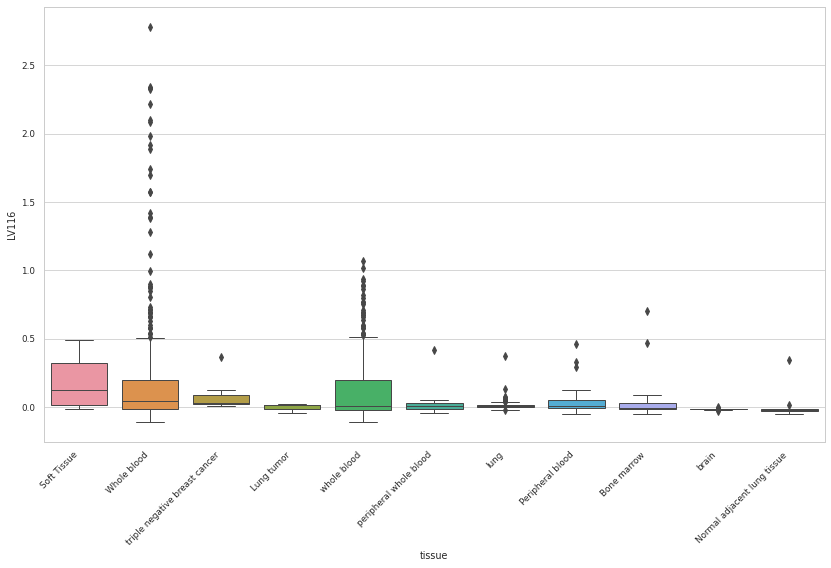

array(['SRP063059', 'SRP045569', 'SRP015670', 'SRP059531', 'SRP062958',
       'SRP039361', 'SRP060370', 'SRP045352', 'SRP048804', 'SRP050246',
       'SRP060416', 'SRP005279', 'SRP042161', 'SRP059701', 'SRP068139',
       'SRP014428', 'SRP041826', 'SRP064259', 'SRP046226', 'SRP066356',
       'SRP041885', 'SRP041647', 'SRP045441', 'SRP044206', 'SRP056443',
       'SRP044593', 'SRP059035', 'SRP054971', 'SRP058237', 'SRP019758'],
      dtype=object)

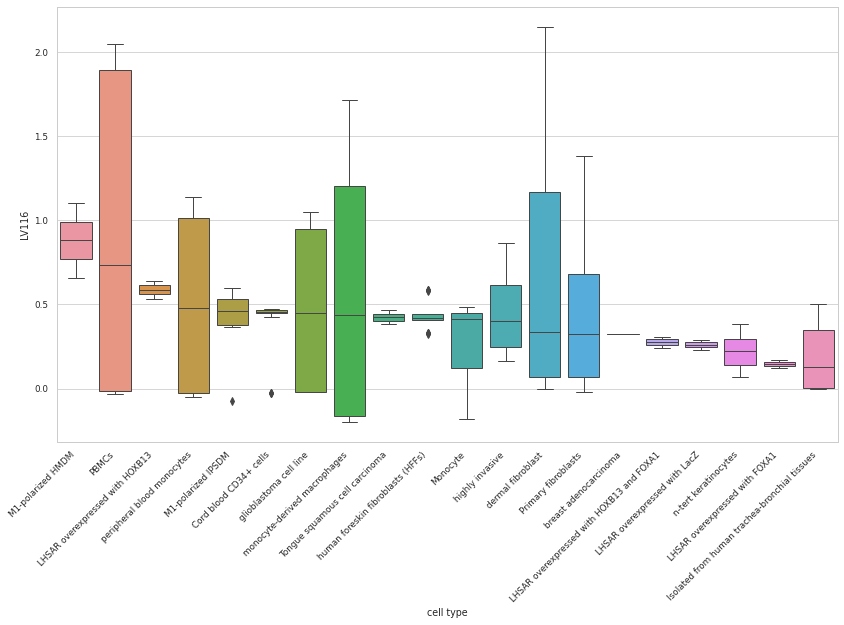

array(['SRP063661'], dtype=object)

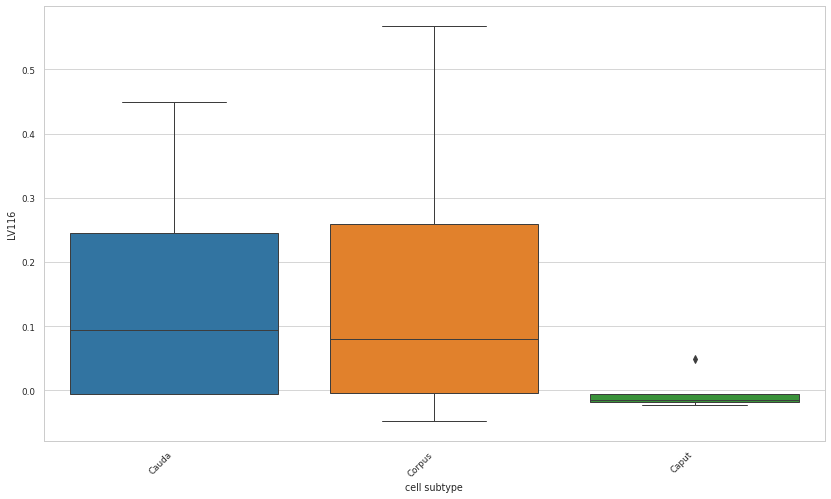

array(['SRP044956', 'SRP019936'], dtype=object)

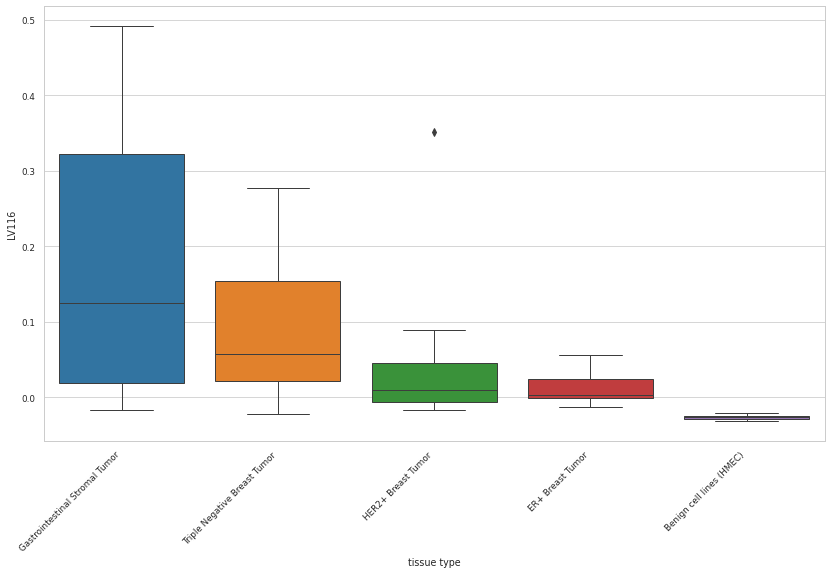

,pathway,LV index,AUC,p-value,FDR
2049,MIPS_SPLICEOSOME,931,0.634804,0.006035,0.031293
2050,PID_TGFBRPATHWAY,931,0.708098,0.008138,0.039896


SRP056295, SRP017138, SRP043080, SRP048759, SRP021191, SRP028594, SRP056197, SRP050272, SRP059735, SRP028554, SRP061932, SRP033266, SRP005279, SRP055390, SRP050493, SRP046233, SRP035679, SRP043033, SRP041885, SRP027358, SRP045500, SRP045352, SRP015360, SRP053046, 

''

inflammatory bowel disease                                                                                                                       3.956483
20003_1199-Treatmentmedication_code_food_supplementplantherbal_extract                                                                           3.681822
22601_23213026-Job_coding_scientific_researcher_scientific_officer_medical_research_associate_experimental_officer                               3.513203
lens disease                                                                                                                                     3.315518
20003_1140876136-Treatmentmedication_code_beconase_50micrograms_nasal_spray                                                                      3.213231
CARDIAC_ARRHYTM-Cardiac_arrhytmias_COPD_comorbidities                                                                                            3.183813
L12_EPIDERMALTHICKOTH-Other_epidermal_thickening                            

''

,gene_name,LV931,gene_band
0,PER1,3.808422,17p13.1
1,MEF2D,3.090195,1q22
2,FOSL2,2.855936,2p23.2
3,RELT,2.831571,11q13.4
4,H1FX,2.815111,3q21.3
5,GNA15,2.733091,19p13.3
6,GNA13,2.345263,17q24.1
7,MCL1,2.329089,1q21.2
8,MED13L,2.245489,12q24.21
9,ELF1,2.218887,13q14.11


cell type       0.056178
tissue          0.047787
cell subtype    0.014120
dtype: float64

array(['SRP056295', 'SRP043080', 'SRP048759', 'SRP021191', 'SRP056197',
       'SRP059735', 'SRP061932', 'SRP033266', 'SRP005279', 'SRP055390',
       'SRP046233', 'SRP043033', 'SRP041885', 'SRP045352', 'SRP053046'],
      dtype=object)

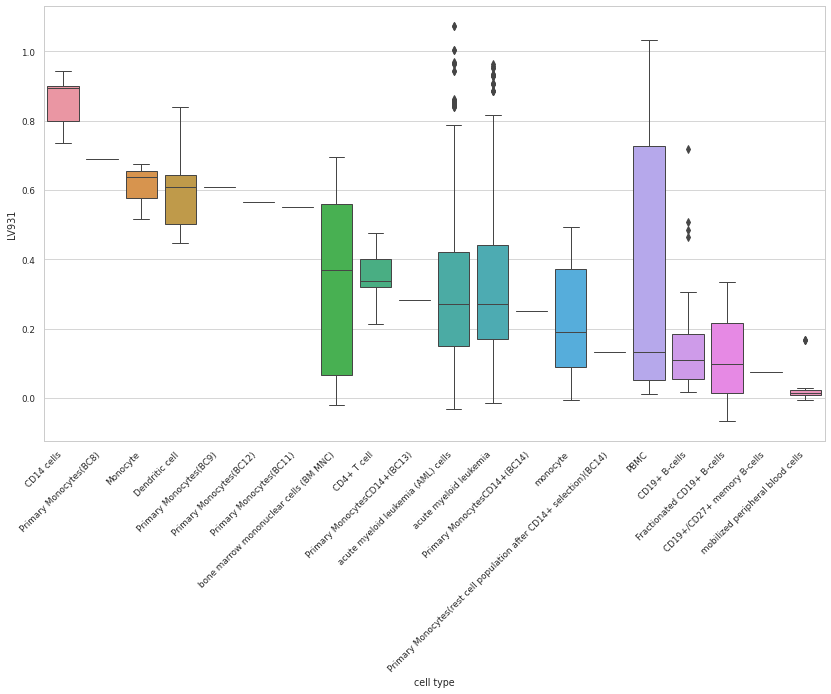

array(['SRP056295', 'SRP048759', 'SRP028594', 'SRP056197', 'SRP059735',
       'SRP028554', 'SRP061932', 'SRP033266', 'SRP005279', 'SRP055390',
       'SRP027358'], dtype=object)

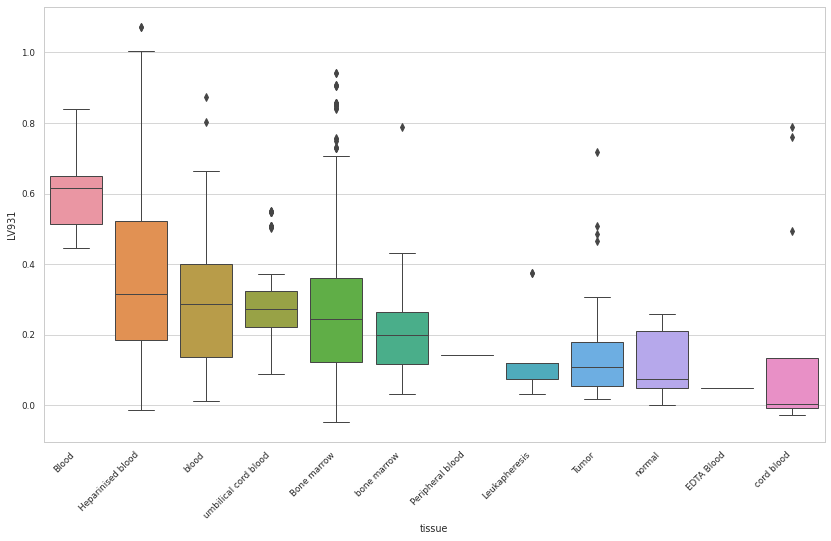

array(['SRP059735'], dtype=object)

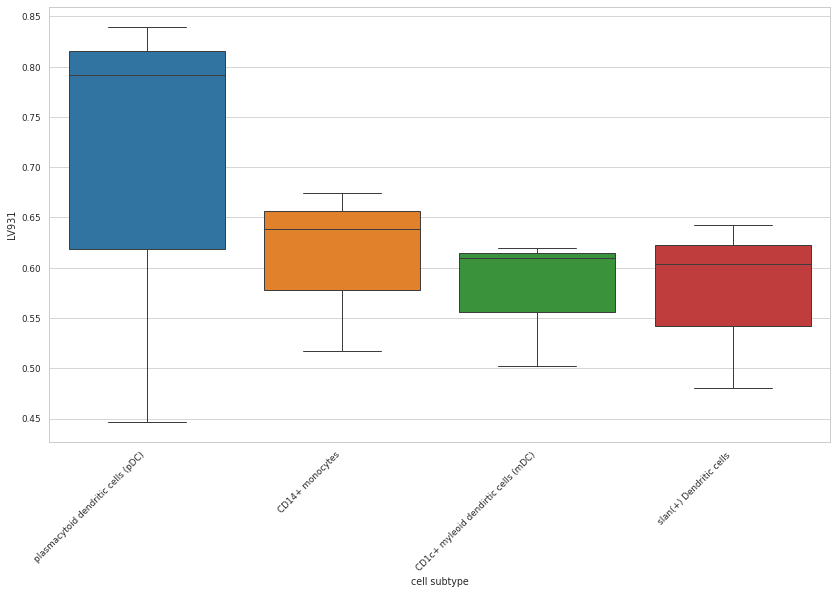

,pathway,LV index,AUC,p-value,FDR


SRP033135, SRP002326, SRP042161, SRP066834, SRP055569, SRP060416, SRP020646, SRP013363, SRP050499, SRP057196, SRP012461, SRP013935, SRP059379, SRP062177, SRP007338, SRP003901, SRP033248, SRP028902, SRP014688, SRP057205, SRP011422, SRP040278, SRP050992, SRP055153, SRP002184, SRP042218, SRP053246, SRP007461, SRP009276, SRP007947, SRP036821, SRP058351, SRP018716, SRP043085, SRP019994, SRP059035, SRP006575, SRP010350, SRP007596, SRP026537, SRP002487, SRP015819, SRP012056, SRP064464, SRP039348, SRP008218, SRP021072, SRP028170, SRP018525, SRP041718, SRP052706, SRP037719, SRP042297, SRP059057, SRP010907, SRP041036, SRP059775, SRP063840, SRP016568, SRP051599, SRP044766, SRP006474, SRP036053, SRP007525, SRP018838, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (64 != 65)
  warnings.warn(


''

6153_1-Medication_for_cholesterol_blood_pressure_diabetes_or_take_exogenous_hormones_Cholesterol_lowering_medication                                               4.876813
6148_5-Eye_problemsdisorders_Macular_degeneration                                                                                                                  4.302356
neurodegenerative disease                                                                                                                                          4.217434
K11_BARRET-Barret_oesophagus                                                                                                                                       4.063377
4609_raw-Longest_period_of_depression                                                                                                                              3.829708
20003_1140852976-Treatmentmedication_code_multivitamins                                                                                     

''

,gene_name,LV744,gene_band
0,UBE3C,8.013408,7q36.3
1,PRMT1,7.087223,19q13.33
2,PSPN,3.539792,19p13.3
3,ATG12,1.847801,5q22.3
4,LGALS1,1.700024,22q13.1
5,PEBP1,1.535039,12q24.23
6,CAV2,1.254037,7q31.2
7,GBF1,0.877145,10q24.32
8,AP2A1,0.872265,19q13.33
9,VIM,0.743348,10p13


cell type         0.014423
tissue            0.001520
tissue subtype    0.000394
dtype: float64

array(['SRP033135', 'SRP042161', 'SRP055569', 'SRP060416', 'SRP057196',
       'SRP012461', 'SRP013935', 'SRP059379', 'SRP062177', 'SRP028902',
       'SRP014688', 'SRP040278', 'SRP050992', 'SRP055153', 'SRP002184',
       'SRP042218', 'SRP053246', 'SRP009276', 'SRP007947', 'SRP043085',
       'SRP059035', 'SRP006575', 'SRP007596', 'SRP026537', 'SRP015819',
       'SRP008218', 'SRP021072', 'SRP018525', 'SRP052706', 'SRP037719',
       'SRP042297', 'SRP063840', 'SRP016568', 'SRP051599', 'SRP044766'],
      dtype=object)

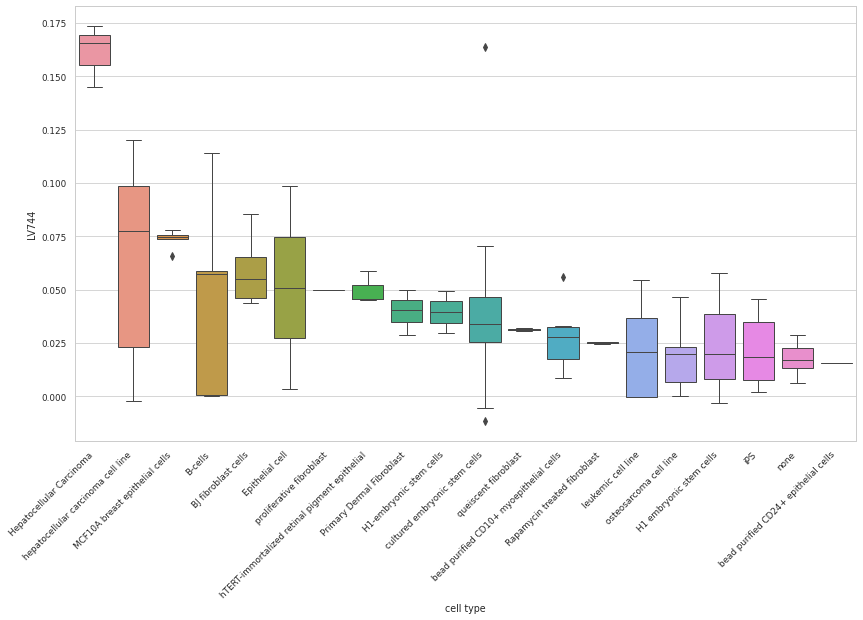

array(['SRP002326', 'SRP066834', 'SRP057196', 'SRP003901', 'SRP033248',
       'SRP011422', 'SRP042218', 'SRP036821', 'SRP058351', 'SRP043085',
       'SRP019994', 'SRP006575', 'SRP039348', 'SRP008218', 'SRP044766',
       'SRP036053'], dtype=object)

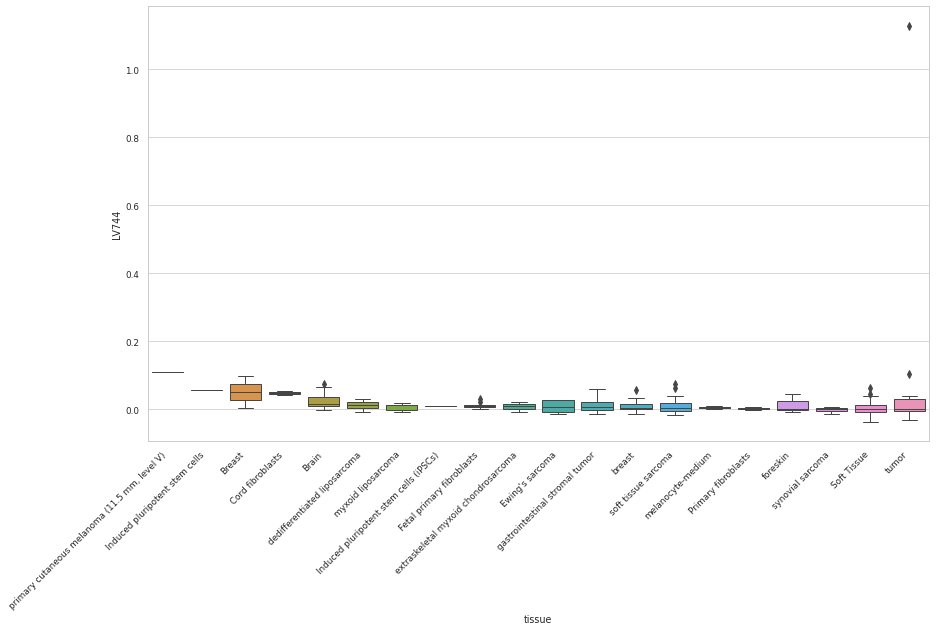

array(['SRP036821'], dtype=object)

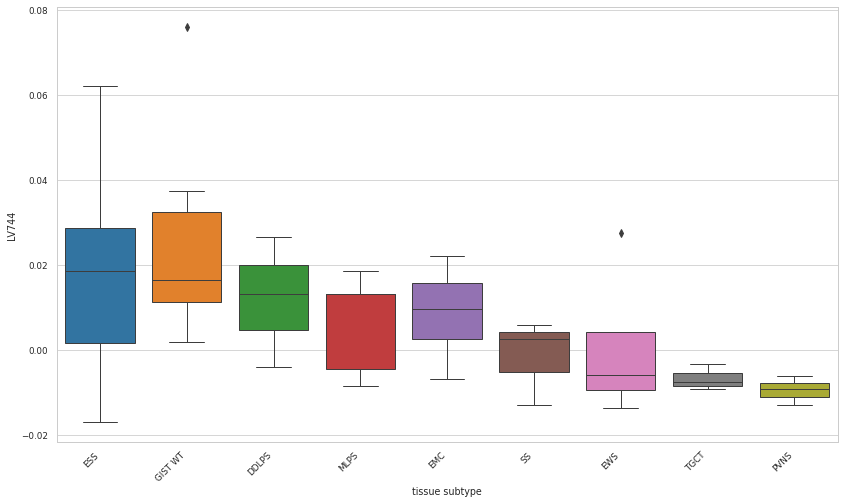

,pathway,LV index,AUC,p-value,FDR


SRP051083, SRP048700, SRP055569, SRP043960, SRP041846, SRP057196, SRP055153, SRP051595, SRP044668, SRP042161, SRP060416, SRP013935, SRP062332, SRP061425, SRP066363, SRP033135, SRP031459, SRP051485, SRP038963, SRP044013, SRP059035, SRP051606, SRP004637, SRP064259, SRP006912, SRP045421, SRP050440, SRP056153, SRP056530, SRP040692, SRP066956, SRP009247, SRP019240, SRP028902, SRP056498, SRP063493, SRP060708, SRP059379, SRP007461, SRP017411, SRP060370, SRP051544, SRP066834, SRP041956, SRP063840, SRP032456, SRP042184, SRP007498, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (47 != 48)
  warnings.warn(


''

1717-Skin_colour                                                                                                  7.227952
1747_4-Hair_colour_natural_before_greying_Dark_brown                                                              5.699803
1727-Ease_of_skin_tanning                                                                                         4.822909
1747_2-Hair_colour_natural_before_greying_Red                                                                     4.496658
1747_5-Hair_colour_natural_before_greying_Black                                                                   4.415438
1737-Childhood_sunburn_occasions                                                                                  3.711494
20003_1141200768-Treatmentmedication_code_protelos_2g_sachets                                                     3.674907
thrombocytopenia                                                                                                  3.531210
22617_5421-Job_S

''

,gene_name,LV697,gene_band
0,PIP4K2C,5.078688,12q13.3
1,CDK4,3.191799,12q14.1
2,MYBL1,2.683990,8q13.1
3,GNS,2.143041,12q14.3
4,MMP24,2.070276,20q11.22
5,TBK1,2.025871,12q14.2
6,FER1L4,1.657136,NaN
7,ATP6V1C1,1.649915,8q22.3
8,ANLN,1.585881,7p14.2
9,CEP250,1.462165,20q11.22


tissue         0.005217
cell type      0.004762
tissue type    0.002278
dtype: float64

array(['SRP057196', 'SRP051595', 'SRP031459', 'SRP004637', 'SRP040692',
       'SRP066834'], dtype=object)

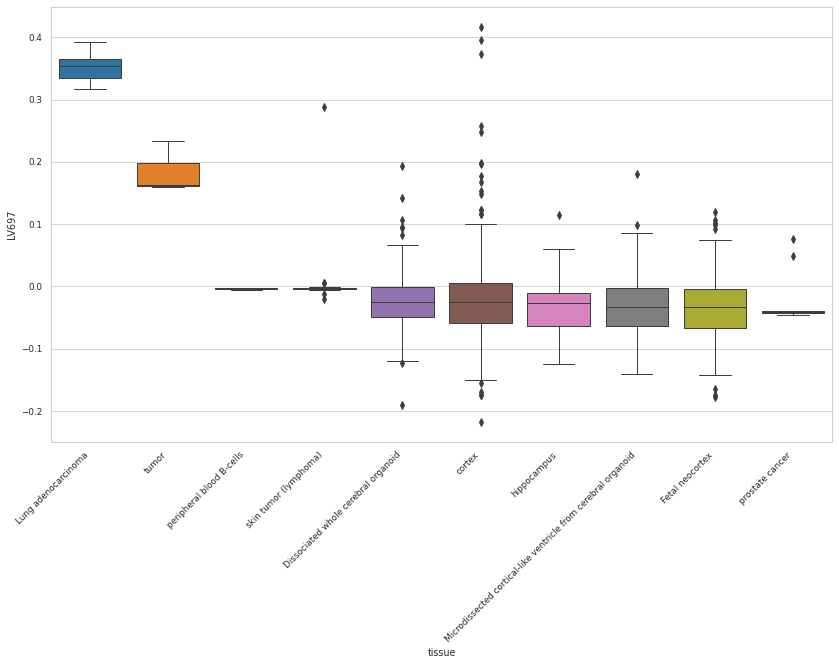

array(['SRP055569', 'SRP041846', 'SRP057196', 'SRP055153', 'SRP042161',
       'SRP060416', 'SRP013935', 'SRP061425', 'SRP033135', 'SRP038963',
       'SRP059035', 'SRP051606', 'SRP064259', 'SRP006912', 'SRP040692',
       'SRP019240', 'SRP028902', 'SRP056498', 'SRP060708', 'SRP059379',
       'SRP017411', 'SRP060370', 'SRP051544', 'SRP041956', 'SRP063840',
       'SRP032456'], dtype=object)

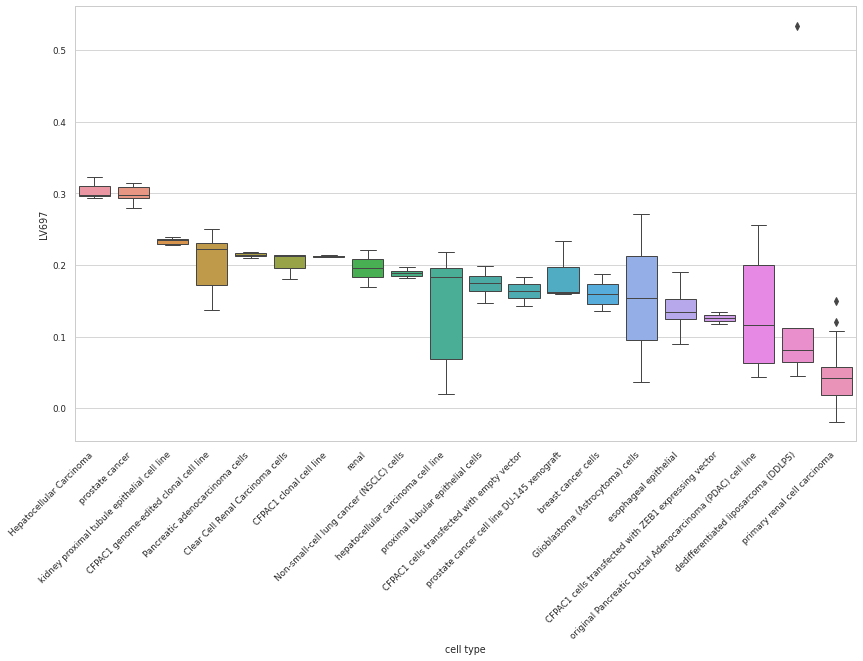

array(['SRP044668'], dtype=object)

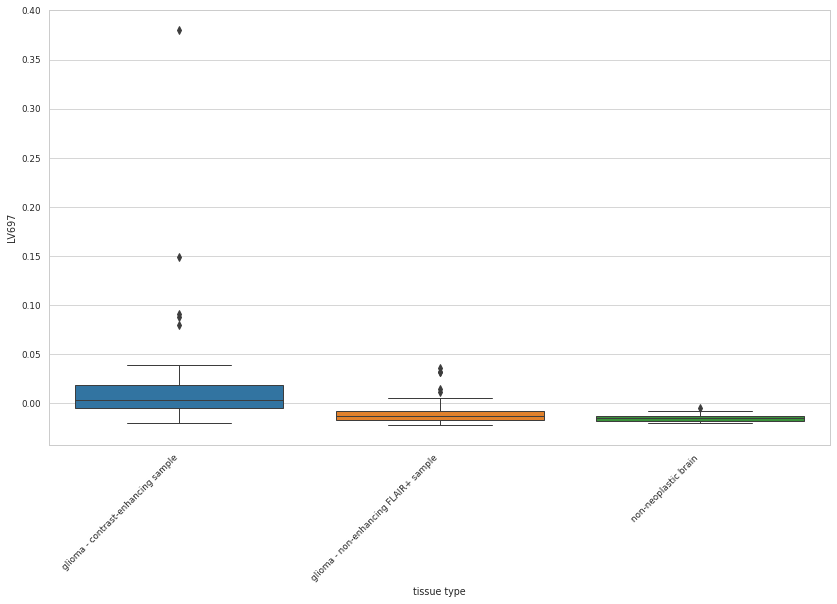

,pathway,LV index,AUC,p-value,FDR


SRP058667, SRP060355, SRP007338, SRP024268, SRP036848, SRP035387, SRP045276, SRP019807, SRP007508, SRP029889, SRP028336, SRP058626, SRP015640, SRP057248, SRP064464, SRP057196, SRP049097, SRP063840, SRP009123, SRP055569, SRP050551, SRP050499, SRP014635, SRP059950, SRP064259, SRP009862, SRP042161, SRP064454, SRP066834, SRP049333, SRP052950, SRP060416, SRP044917, SRP051249, SRP007498, SRP003901, SRP051485, SRP030401, SRP007881, SRP029603, SRP040998, SRP011578, SRP019810, SRP050003, SRP009247, SRP026620, SRP033135, SRP051472, SRP066956, SRP029262, SRP051705, SRP061701, SRP012167, SRP057244, SRP026454, SRP040442, SRP041377, SRP051822, SRP059035, SRP055438, SRP016583, SRP006575, SRP057586, SRP014027, SRP042620, SRP015668, SRP010279, SRP014213, SRP056696, SRP027364, SRP037982, SRP001997, SRP051825, SRP057205, SRP007412, SRP052057, SRP058722, SRP018853, SRP016140, SRP059775, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (78 != 80)
  warnings.warn(


''

deep vein thrombosis                                                                                                       4.024093
6152_5-Blood_clot_DVT_bronchitis_emphysema_asthma_rhinitis_eczema_allergy_diagnosed_by_doctor_Blood_clot_in_the_leg_DVT    3.692777
fasting blood insulin measurement                                                                                          3.619170
6154_1-Medication_for_pain_relief_constipation_heartburn_Aspirin                                                           3.501838
coronary artery disease                                                                                                    3.425030
20023_raw-Mean_time_to_correctly_identify_matches                                                                          3.302193
20437-Thoughts_of_death_during_worst_depression                                                                            3.289111
I9_VTE-Venous_thromboembolism                                               

''

,gene_name,LV885,gene_band
0,PTGER3,4.915498,1p31.1
1,EGF,3.674184,4q25
2,UGT1A8,3.321914,2q37.1
3,NME7,2.705729,1q24.2
4,AK4,2.687147,1p31.3
5,ATP1B1,2.502304,1q24.2
6,COBLL1,2.280220,2q24.3
7,SLC12A1,2.103986,NaN
8,SLC44A3,1.867042,1p21.3
9,SLC3A1,1.864666,2p21


tissue type       0.981002
tissue subtype    0.267152
tissue            0.009514
cell type         0.003382
cell subtype      0.002075
dtype: float64

array(['SRP058667', 'SRP049097'], dtype=object)

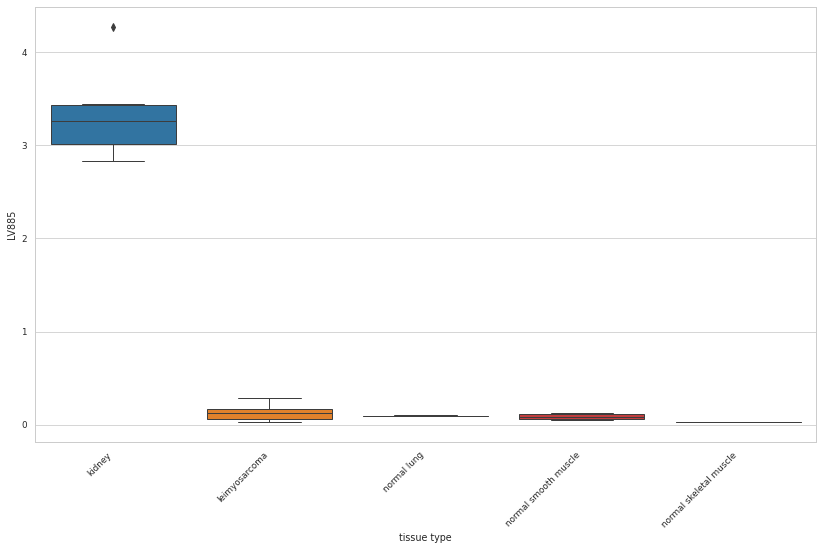

array(['SRP058667'], dtype=object)

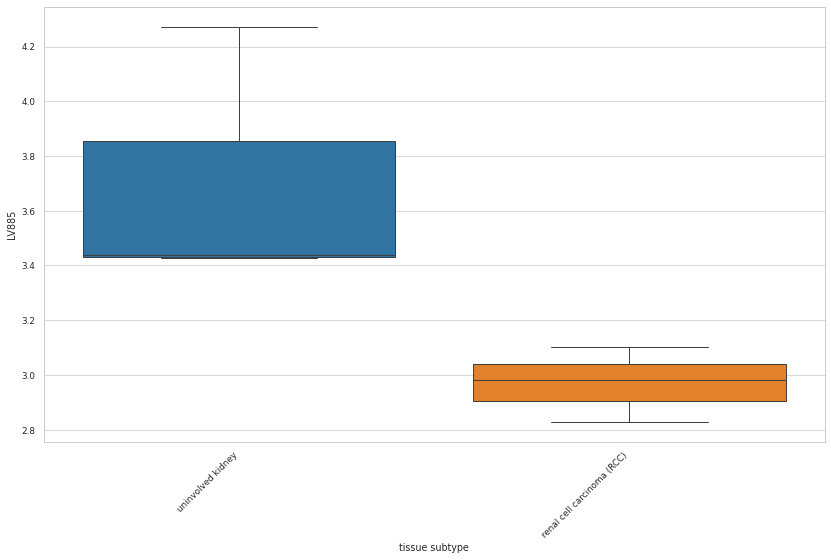

array(['SRP060355', 'SRP024268', 'SRP036848', 'SRP045276', 'SRP019807',
       'SRP029889', 'SRP028336', 'SRP058626', 'SRP057196', 'SRP049097',
       'SRP009123', 'SRP050551', 'SRP014635', 'SRP066834', 'SRP049333',
       'SRP052950', 'SRP003901', 'SRP007881', 'SRP050003', 'SRP029262',
       'SRP012167', 'SRP040442', 'SRP016583', 'SRP006575', 'SRP042620',
       'SRP015668', 'SRP056696', 'SRP027364', 'SRP037982', 'SRP051825',
       'SRP058722'], dtype=object)

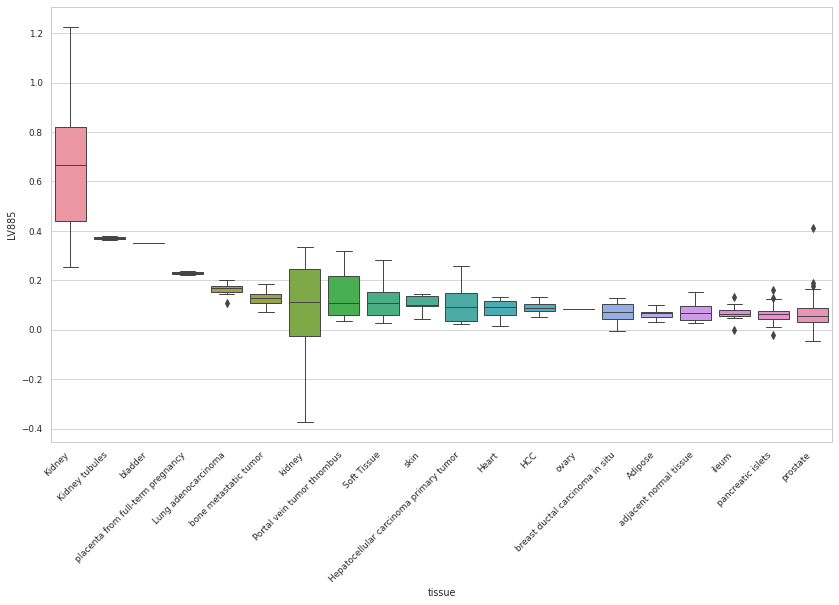

array(['SRP035387', 'SRP007508', 'SRP058626', 'SRP015640', 'SRP057196',
       'SRP063840', 'SRP055569', 'SRP064259', 'SRP042161', 'SRP064454',
       'SRP060416', 'SRP044917', 'SRP011578', 'SRP019810', 'SRP050003',
       'SRP026620', 'SRP033135', 'SRP026454', 'SRP051822', 'SRP059035',
       'SRP006575', 'SRP014027', 'SRP014213', 'SRP001997', 'SRP016140'],
      dtype=object)

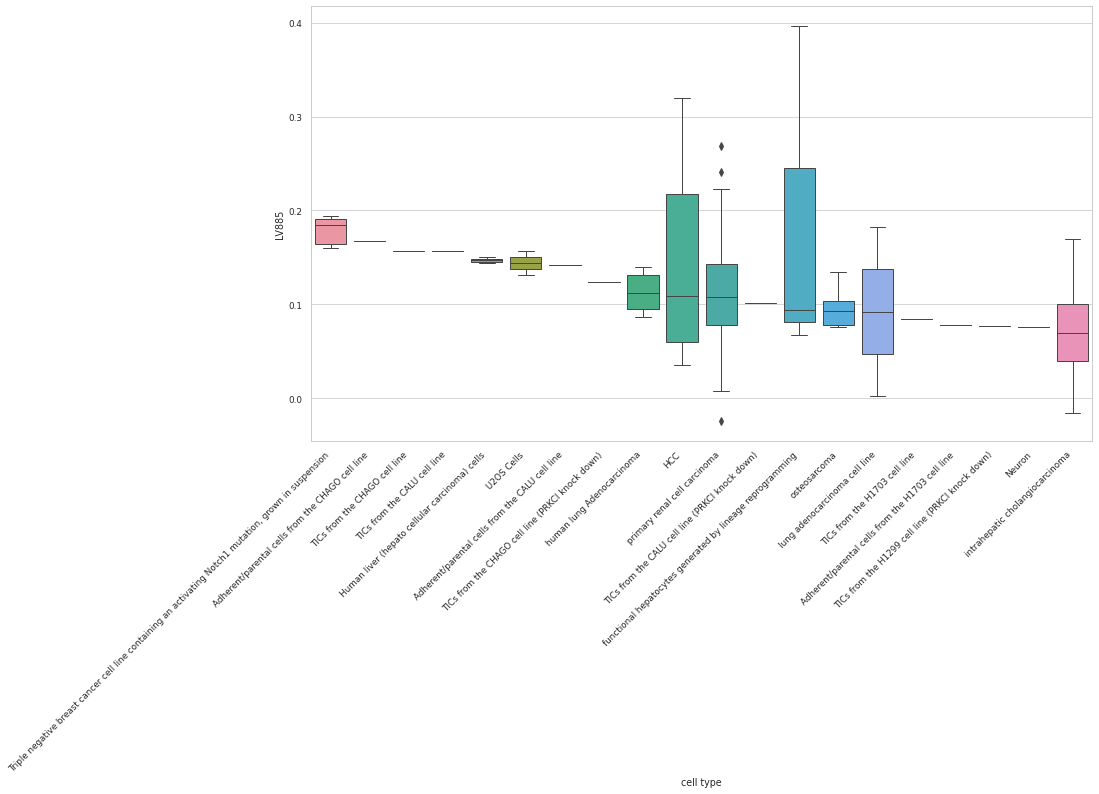

array(['SRP064454'], dtype=object)

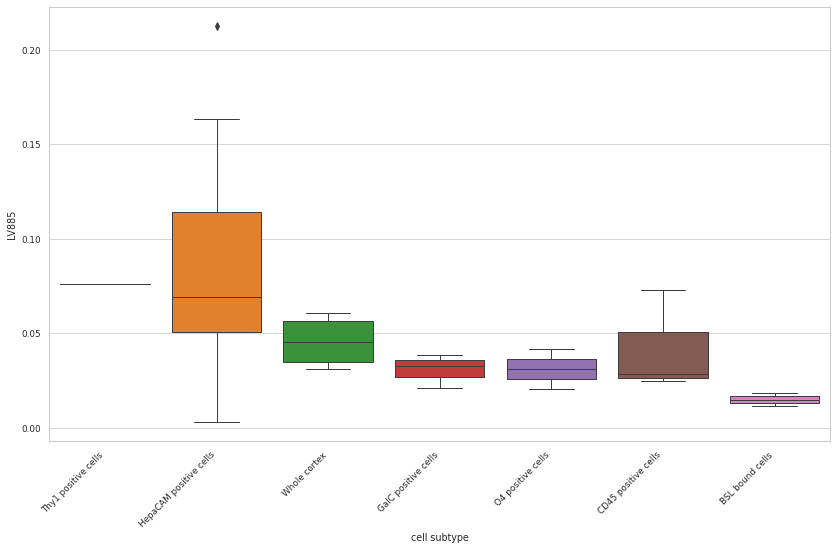

,pathway,LV index,AUC,p-value,FDR


SRP007947, SRP003901, SRP055569, SRP037722, SRP008218, SRP066834, SRP015013, SRP060416, SRP019994, SRP057196, SRP042161, SRP058773, SRP012557, SRP050499, SRP055153, SRP059379, SRP030617, SRP005279, SRP051606, SRP003754, SRP058841, SRP009247, SRP050497, SRP018104, SRP007508, SRP008145, SRP041377, SRP002326, SRP035478, SRP033135, SRP017777, SRP055440, SRP057248, SRP000599, SRP013450, SRP014213, SRP055513, SRP042218, SRP034543, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (37 != 39)
  warnings.warn(


''

20003_1140861954-Treatmentmedication_code_fenofibrate                                                                    4.294382
104530-Orange_intake                                                                                                     3.900886
I9_HEARTFAIL_NS-Heart_failure_not_strict                                                                                 3.529004
I9_HEARTFAIL-Heart_failurestrict                                                                                         3.529004
HEARTFAIL-Heart_failure                                                                                                  3.529004
syncope                                                                                                                  3.498068
22601_24513035-Job_coding_librarian_assistant_librarian                                                                  3.399424
6141_8-How_are_people_in_household_related_to_participant_Other_unrelated                 

''

,gene_name,LV536,gene_band
0,GTF2IRD1,6.397333,7q11.23
1,TAGLN,5.519838,11q23.3
2,HIST3H2BB,4.543711,1q42.13
3,PIAS1,3.546184,15q23
4,TMEM71,3.175580,8q24.22
5,PCBP1,2.948925,2p13.3
6,EGR1,2.824492,5q31.2
7,ACTR3,2.752111,2q14.1
8,APAF1,2.561194,12q23.1
9,MAGEH1,2.505184,NaN


cell type    0.029240
tissue       0.009666
dtype: float64

array(['SRP007947', 'SRP055569', 'SRP037722', 'SRP008218', 'SRP060416',
       'SRP057196', 'SRP042161', 'SRP055153', 'SRP059379', 'SRP005279',
       'SRP051606', 'SRP007508', 'SRP033135', 'SRP013450', 'SRP014213',
       'SRP042218', 'SRP034543'], dtype=object)

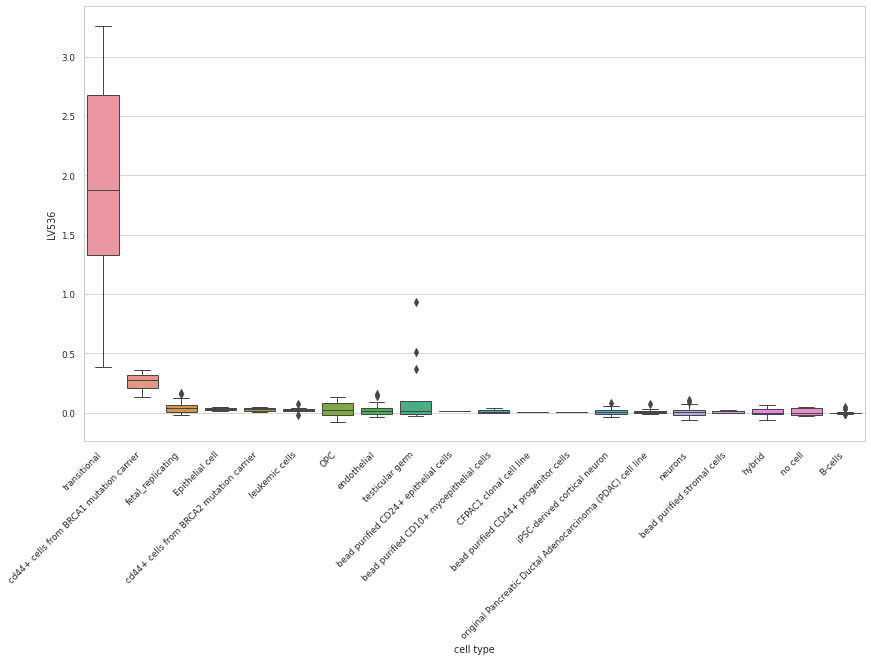

array(['SRP003901', 'SRP008218', 'SRP066834', 'SRP019994', 'SRP057196',
       'SRP005279', 'SRP002326', 'SRP017777', 'SRP055513', 'SRP042218'],
      dtype=object)

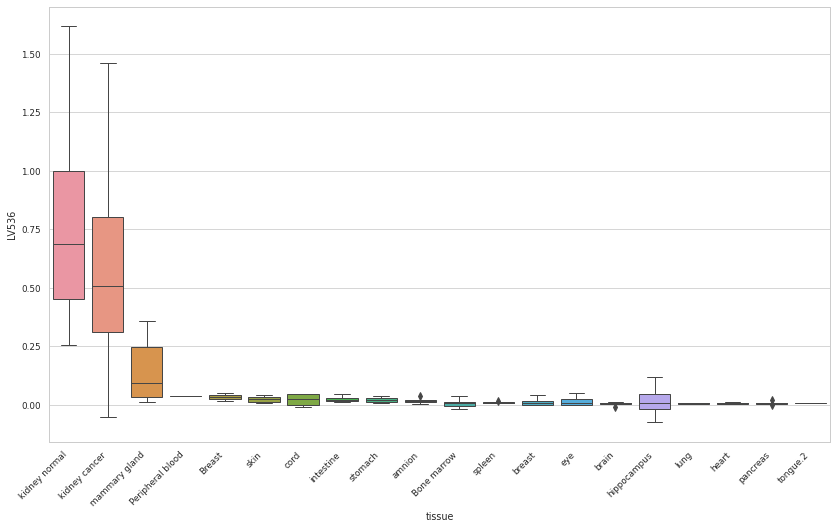

,pathway,LV index,AUC,p-value,FDR


SRP055569, SRP033135, SRP051606, SRP009247, SRP057196, SRP066834, SRP060416, SRP012557, SRP049097, SRP019994, SRP042161, SRP017933, SRP065559, SRP058773, SRP007498, SRP012461, SRP050497, SRP019807, SRP041396, SRP019936, SRP030617, SRP055438, SRP050499, SRP045352, SRP042620, SRP055153, SRP055810, SRP051825, SRP064464, SRP018853, SRP055392, SRP002184, SRP009266, SRP063840, SRP006474, SRP015845, SRP026315, SRP059733, SRP048820, SRP036848, SRP059035, SRP034007, SRP015013, SRP011578, SRP058667, SRP009862, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (43 != 46)
  warnings.warn(


''

41248_8002-Destinations_on_discharge_from_hospital_recoded_Other_hospital_NonNHS                                                      3.978492
20107_10-Illnesses_of_father_Alzheimers_diseasedementia                                                                               3.532805
22601_91392832-Job_coding_other_work_in_this_industry_factory_hand_mate_assistant_handler_loader                                      3.509538
20003_1140868170-Treatmentmedication_code_prochlorperazine                                                                            3.421248
6152_9-Blood_clot_DVT_bronchitis_emphysema_asthma_rhinitis_eczema_allergy_diagnosed_by_doctor_Hayfever_allergic_rhinitis_or_eczema    3.343142
22601_61223105-Job_coding_childminder_au_pair_childrens_nanny                                                                         3.264615
20433_raw-Age_at_first_episode_of_depression                                                                                          3.256141

''

,gene_name,LV550,gene_band
0,SEC23A,7.336220,14q21.1
1,LPP,6.631632,3q27.3
2,SUPT5H,5.822339,19q13.2
3,NCBP2,3.312370,3q29
4,SLC7A11,3.187730,4q28.3
5,ATP5I,1.198183,4p16.3
6,VAMP2,1.054193,17p13.1
7,GRIN3B,1.037896,19p13.3
8,PRDX4,1.018353,NaN
9,MYL6,0.999869,12q13.2


cell type         0.020755
tissue type       0.005532
tissue subtype    0.001955
tissue            0.001612
dtype: float64

array(['SRP055569', 'SRP033135', 'SRP051606', 'SRP057196', 'SRP060416',
       'SRP042161', 'SRP012461', 'SRP045352', 'SRP055153', 'SRP002184',
       'SRP063840', 'SRP026315', 'SRP048820', 'SRP059035', 'SRP034007',
       'SRP011578'], dtype=object)

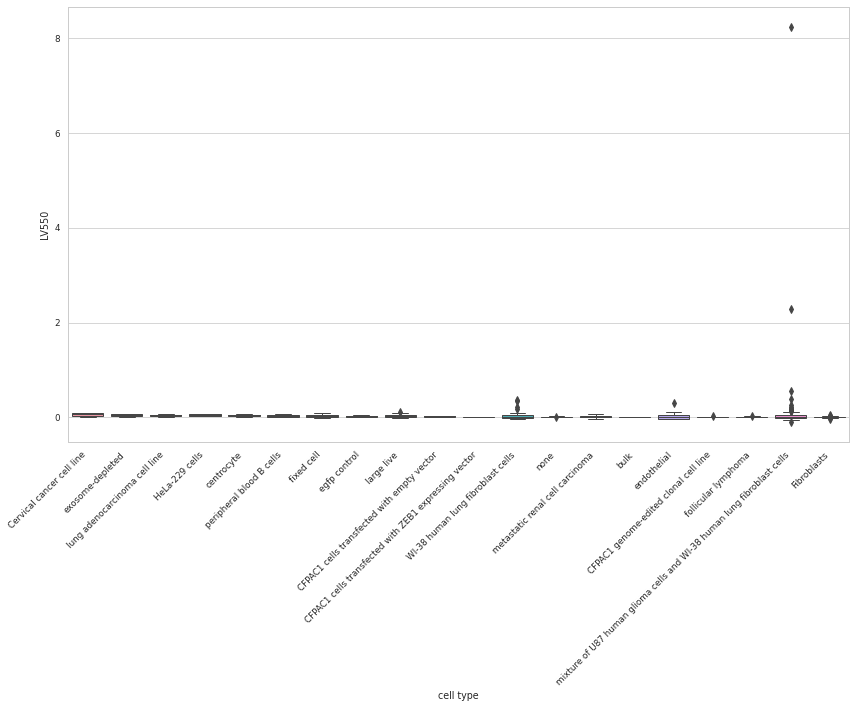

array(['SRP049097', 'SRP019936', 'SRP058667'], dtype=object)

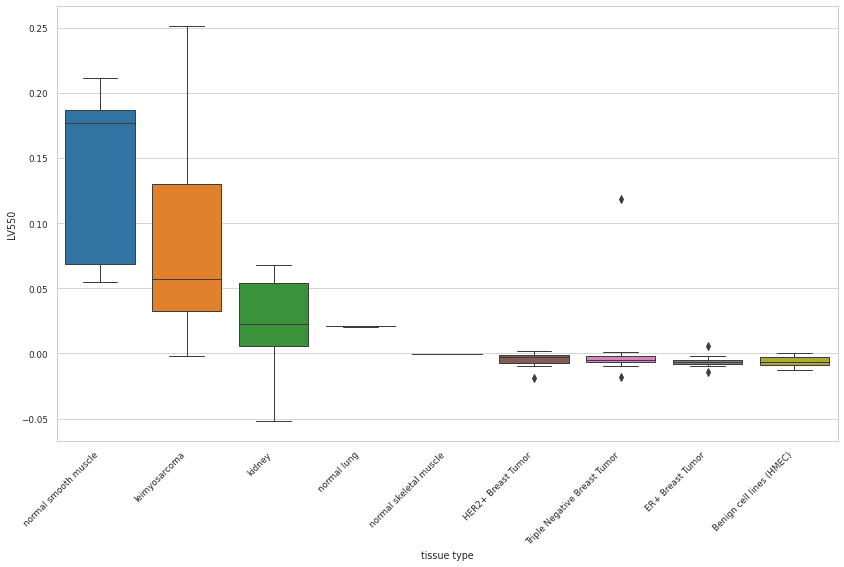

array(['SRP058667'], dtype=object)

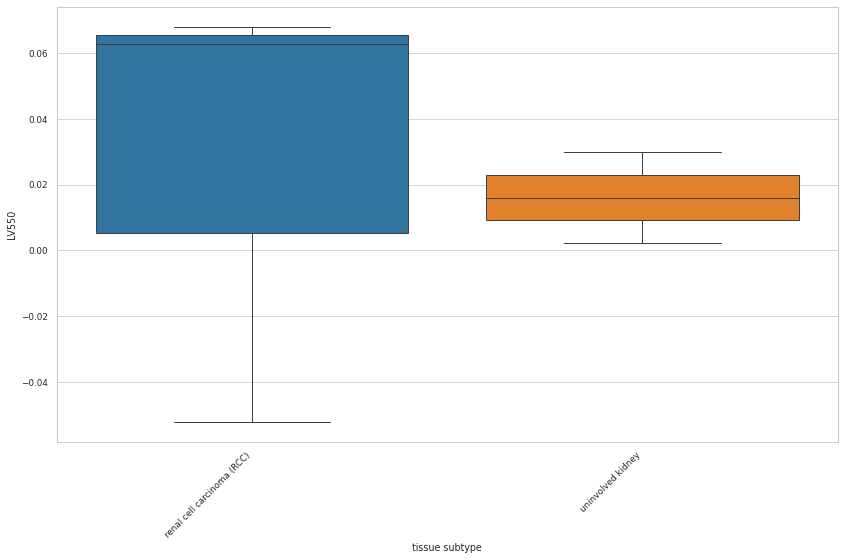

array(['SRP057196', 'SRP066834', 'SRP049097', 'SRP019994', 'SRP017933',
       'SRP065559', 'SRP019807', 'SRP042620', 'SRP051825', 'SRP048820',
       'SRP036848'], dtype=object)

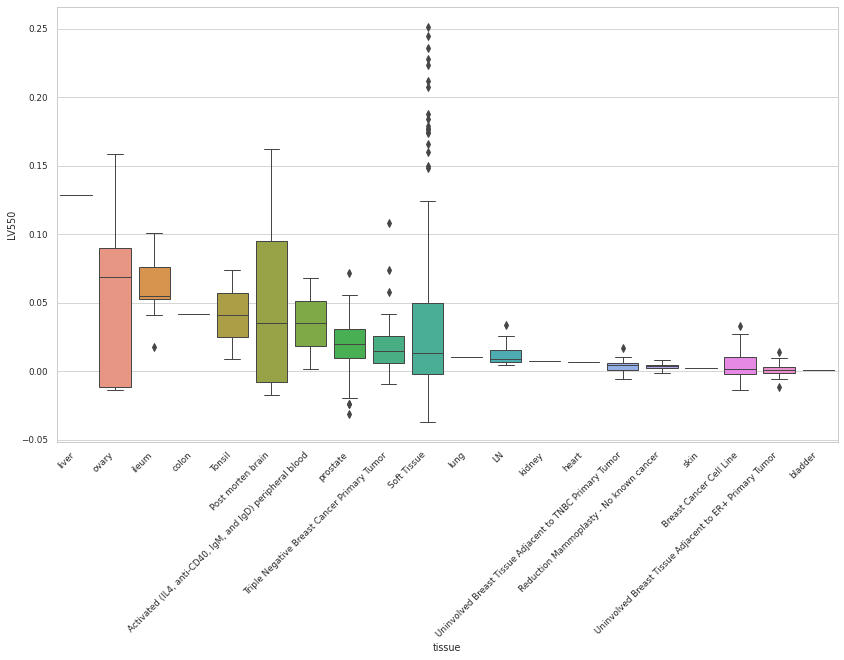

,pathway,LV index,AUC,p-value,FDR


SRP042161, SRP060416, SRP050499, SRP055569, SRP033135, SRP066834, SRP059379, SRP057196, SRP009266, SRP003901, SRP018838, SRP055153, SRP011546, SRP064464, SRP063840, SRP059775, SRP015449, SRP050992, SRP059035, SRP049238, SRP047192, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (20 != 21)
  warnings.warn(


''

1727-Ease_of_skin_tanning                                                                     5.367754
1717-Skin_colour                                                                              5.314110
1747_2-Hair_colour_natural_before_greying_Red                                                 5.173396
22601_92513331-Job_coding_shelf_filler_or_stacker_stock_handler_display_assistant             3.739010
22617_9251-Job_SOC_coding_Shelf_fillers                                                       3.709472
22601_35623246-Job_coding_personnel_or_industrial_relations_officer_recruitment_consultant    3.554174
H7_EYELIDNAS-Other_specified_and_unspecified_disorders_of_eyelid                              3.540660
optic neuritis                                                                                3.513039
22617_3213-Job_SOC_coding_Paramedics                                                          3.391513
1747_4-Hair_colour_natural_before_greying_Dark_brown                     

''

,gene_name,LV220,gene_band
0,TK2,6.747421,16q21
1,KLHL13,6.351510,NaN
2,ZNF582,5.792081,19q13.43
3,NCOA6,4.585452,20q11.22
4,EXOC6,4.396436,10q23.33
5,AXIN1,4.001346,16p13.3
6,UQCRC2,2.715914,16p12.2
7,COPS5,2.618104,8q13.1
8,CLDN10,2.553393,13q32.1
9,LAP3,2.544806,4p15.32


cell type    0.033557
tissue       0.003967
dtype: float64

array(['SRP042161', 'SRP060416', 'SRP055569', 'SRP033135', 'SRP059379',
       'SRP057196', 'SRP055153', 'SRP011546', 'SRP063840', 'SRP050992',
       'SRP059035', 'SRP049238', 'SRP047192'], dtype=object)

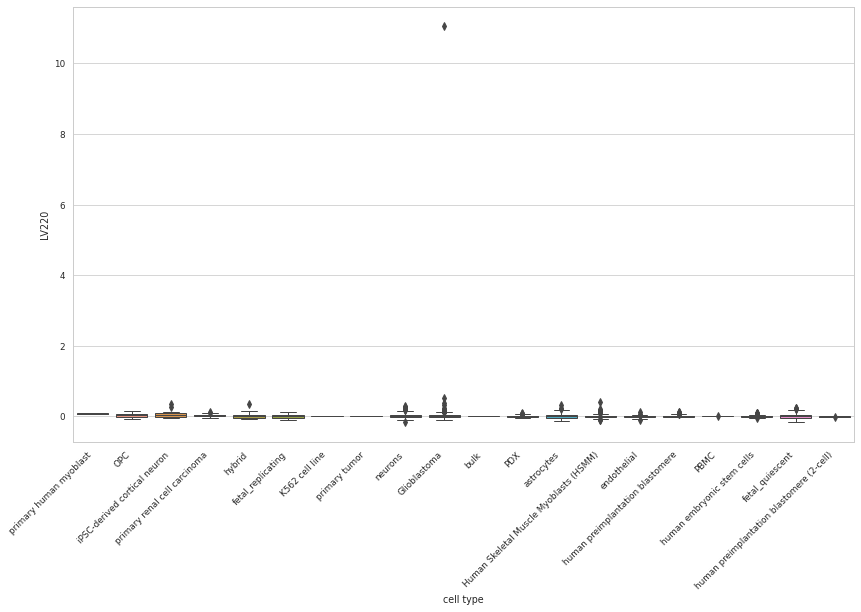

array(['SRP066834', 'SRP057196', 'SRP003901', 'SRP011546', 'SRP047192'],
      dtype=object)

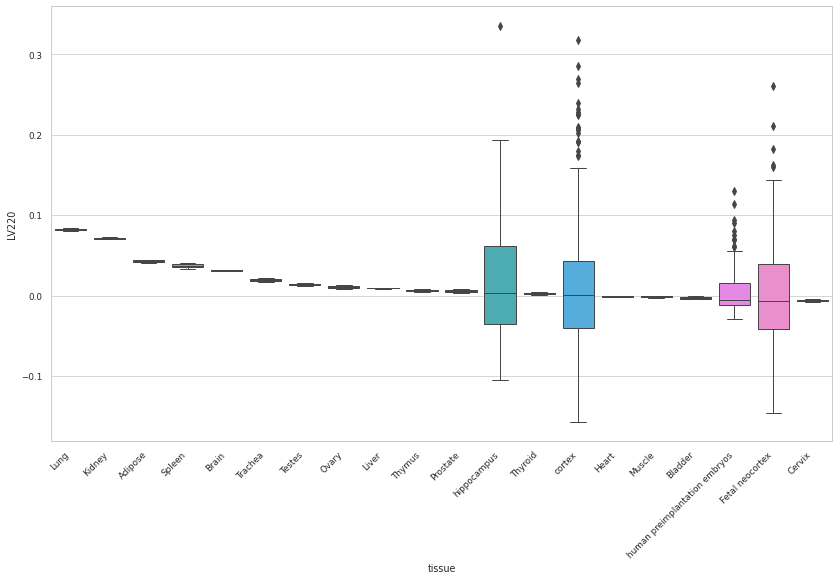

,pathway,LV index,AUC,p-value,FDR


SRP055569, SRP042161, SRP006474, SRP033135, SRP017575, SRP036821, SRP006575, SRP057196, SRP009266, SRP050499, SRP066834, SRP065202, SRP019994, SRP060416, SRP047192, SRP005279, SRP059775, SRP049097, SRP059379, SRP058773, SRP007359, SRP061241, SRP012461, SRP009862, SRP042620, SRP049713, SRP014620, SRP057745, SRP003754, SRP033369, SRP033276, SRP014428, SRP027383, SRP049238, SRP045322, SRP062230, SRP024268, SRP058841, SRP018838, SRP002915, SRP055810, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (38 != 41)
  warnings.warn(


''

H8_MENIERE-Ménière_disease                                                        4.259936
TRAUMBRAIN_NONCONCUS-severe_traumatic_brain_injury_does_not_include_concussion    3.912594
22601_52232941-Job_coding_motor_vehicleindustrial_machinery_fitter                3.883046
anxiety AND panic disorder                                                        3.787045
20471-Ever_seen_an_unreal_vision                                                  3.675024
M13_SOFTOVERUSE-Soft_tissue_disorders_related_to_use_overuse_and_pressure         3.523381
20554_4-Actions_taken_following_selfharm_Use_a_helpline_voluntary_organization    3.430470
5158_raw-6mm_asymmetry_index_right                                                3.392353
20003_1141168752-Treatmentmedication_code_peptac_liquid                           3.289474
20090_368-Type_of_fatoil_used_in_cooking_Normal_fat_olive_spread                  3.209467
20003_1140861276-Treatmentmedication_code_lacidipine                              3.200511

''

,gene_name,LV272,gene_band
0,GGCT,6.796871,7p14.3
1,HMGN1,6.128429,21q22.2
2,GNPNAT1,5.657774,14q22.1
3,TLE2,5.438517,19p13.3
4,DDB1,4.499474,11q12.2
5,HECTD3,3.632601,1p34.1
6,FOXM1,2.823613,12p13.33
7,CPSF6,2.789736,12q15
8,GUK1,2.705362,1q42.13
9,STX12,2.356745,1p35.3


cell type         0.034941
tissue subtype    0.005081
tissue            0.001514
tissue type       0.000793
dtype: float64

array(['SRP055569', 'SRP042161', 'SRP033135', 'SRP006575', 'SRP057196',
       'SRP065202', 'SRP060416', 'SRP047192', 'SRP005279', 'SRP059379',
       'SRP012461', 'SRP049713', 'SRP014620', 'SRP014428', 'SRP049238',
       'SRP045322', 'SRP062230'], dtype=object)

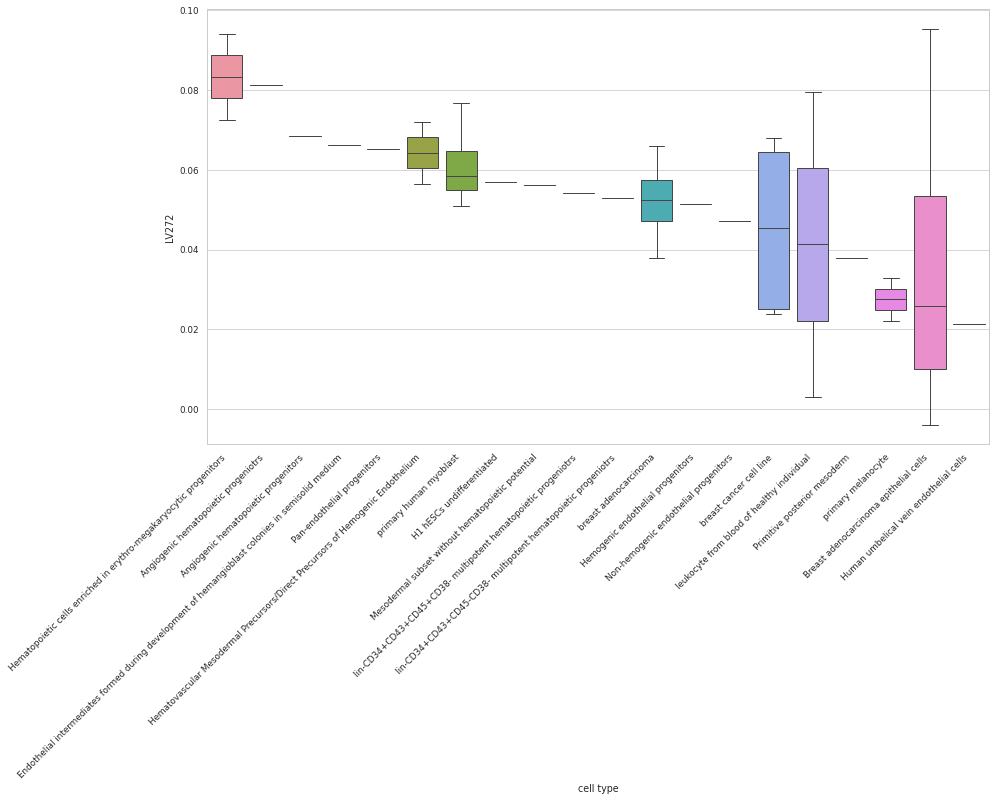

array(['SRP036821'], dtype=object)

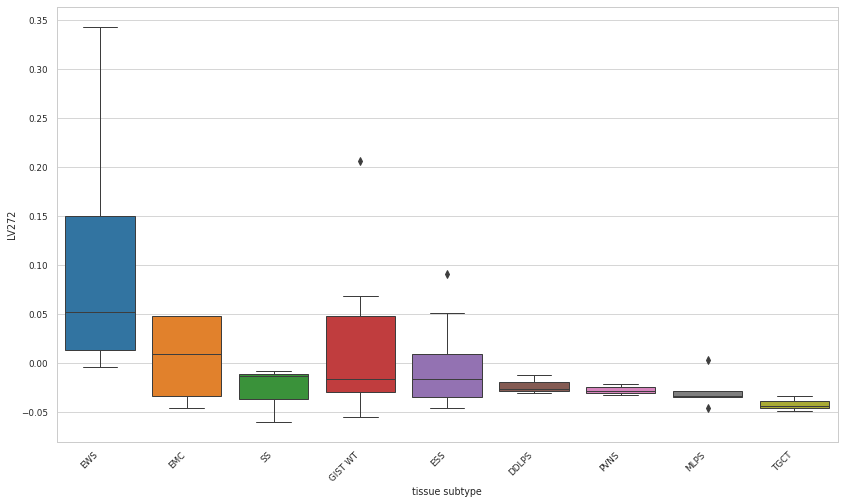

array(['SRP017575', 'SRP036821', 'SRP006575', 'SRP057196', 'SRP066834',
       'SRP019994', 'SRP047192', 'SRP005279', 'SRP049097', 'SRP007359',
       'SRP061241', 'SRP042620', 'SRP033276', 'SRP014428', 'SRP024268'],
      dtype=object)

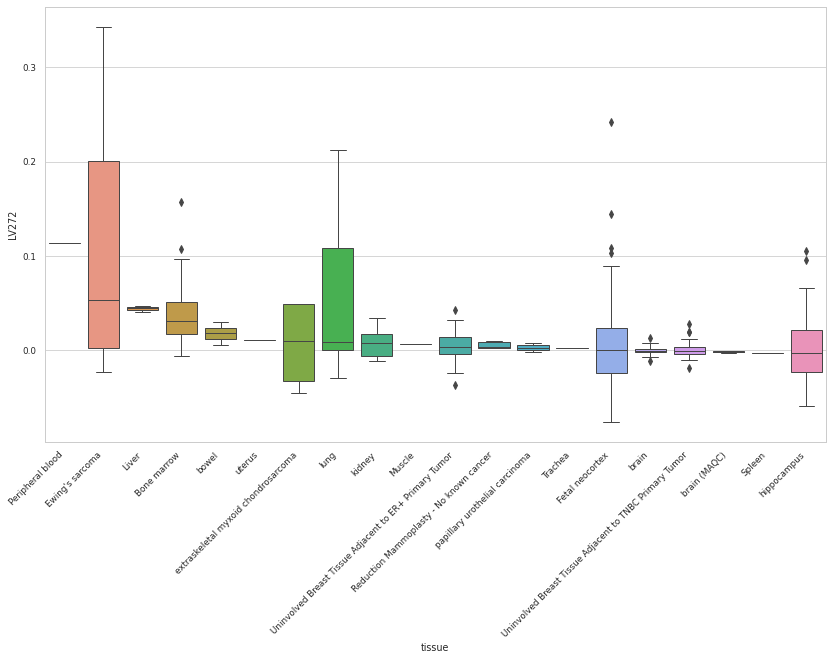

array(['SRP049097'], dtype=object)

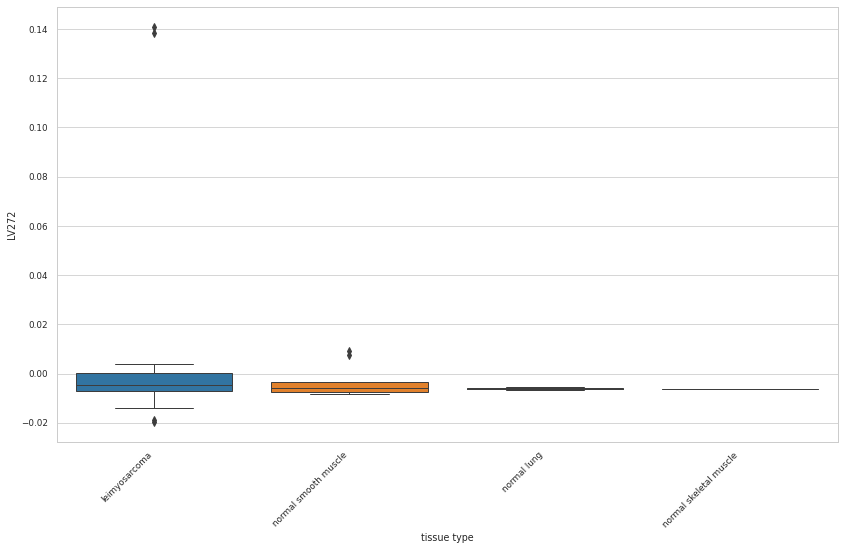

,pathway,LV index,AUC,p-value,FDR
1716,REACTOME_GENERIC_TRANSCRIPTION_PATHWAY,739,0.708383,4.784901e-09,1.340394e-07
1719,MIPS_SPLICEOSOME,739,0.672691,9.382020e-04,7.362372e-03


SRP042161, SRP066834, SRP059379, SRP009862, SRP057196, SRP062025, SRP063840, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (6 != 7)
  warnings.warn(


''

30280_raw-Immature_reticulocyte_fraction                                                                                                              3.721799
20113_2-Illnesses_of_adopted_mother_Stroke                                                                                                            3.509469
neuroma                                                                                                                                               3.471451
23110_raw-Impedance_of_arm_left                                                                                                                       3.150137
6177_1-Medication_for_cholesterol_blood_pressure_or_diabetes_Cholesterol_lowering_medication                                                          3.079800
22650_0-Night_shifts_worked_Shift_pattern_was_worked_for_some_but_not_all_of_job                                                                      3.075837
K11_OTHGASTR-Other_gastritis_incl_Duodenitis  

''

,gene_name,LV739,gene_band
0,SPDYE1,2.243837,7p13
1,ZNF426,2.227499,19p13.2
2,IL1RAP,2.169030,3q28
3,PJA2,2.165395,5q21.3
4,TAF7,2.007086,5q31.3
5,ZNF433,1.994523,19p13.2
6,CLDN12,1.959332,7q21.13
7,ZNF317,1.946576,19p13.2
8,DDX41,1.877848,5q35.3
9,ZNF548,1.825731,19q13.43


cell type         0.070015
cell phenotype    0.016195
tissue            0.012850
dtype: float64

array(['SRP042161', 'SRP059379', 'SRP057196', 'SRP063840'], dtype=object)

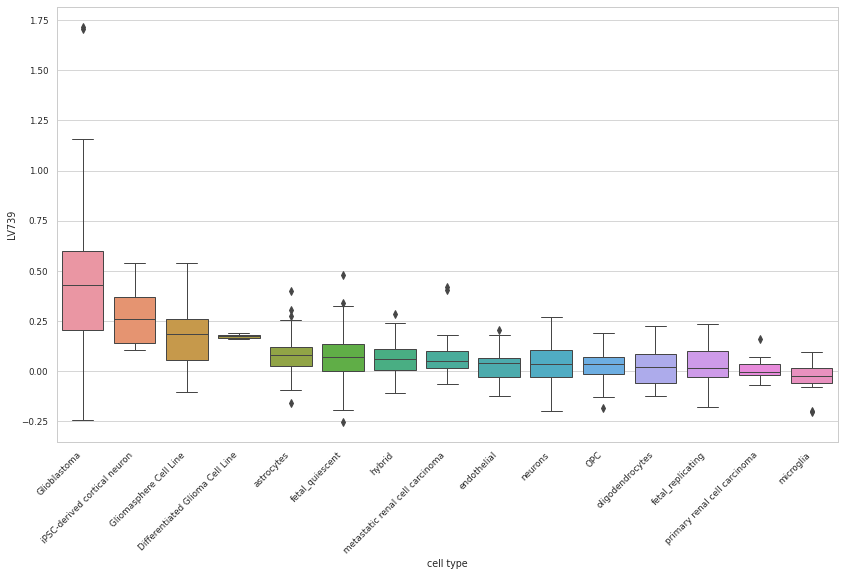

array(['SRP062025'], dtype=object)

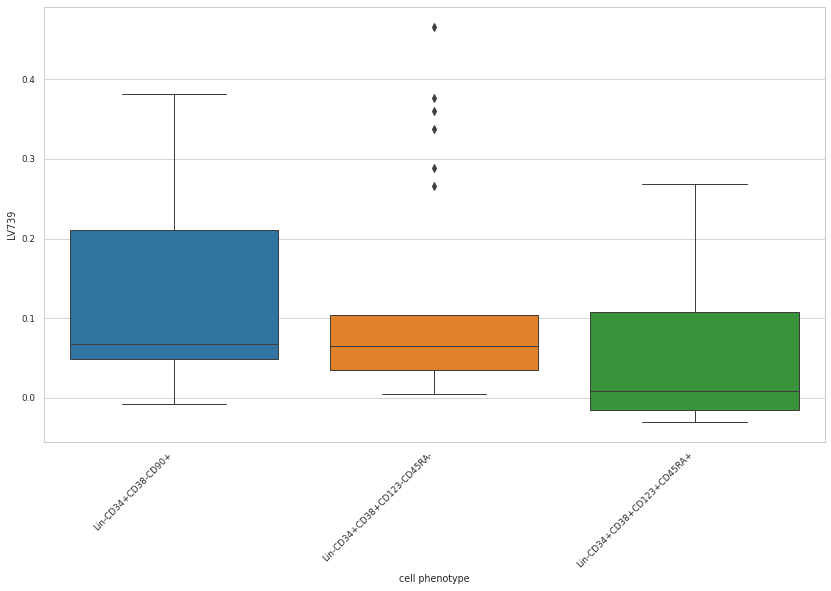

array(['SRP066834', 'SRP057196', 'SRP062025'], dtype=object)

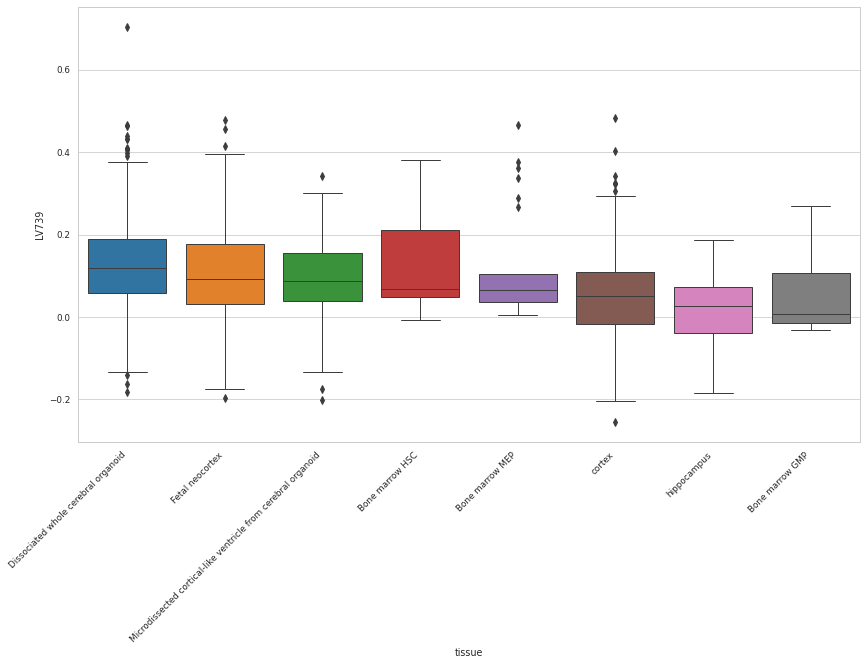

,pathway,LV index,AUC,p-value,FDR
1629,REACTOME_MITOCHONDRIAL_PROTEIN_IMPORT,678,0.742277,3.476169e-03,1.994175e-02
1631,KEGG_OXIDATIVE_PHOSPHORYLATION,678,0.982290,5.458481e-16,5.747488e-14
1633,REACTOME_TCA_CYCLE_AND_RESPIRATORY_ELECTRON_TR...,678,0.856376,2.596467e-10,9.656171e-09
1635,REACTOME_RESPIRATORY_ELECTRON_TRANSPORT_ATP_SY...,678,0.988348,1.054241e-12,5.939594e-11
1636,REACTOME_RESPIRATORY_ELECTRON_TRANSPORT,678,0.998043,7.331802e-11,3.100921e-09
1637,REACTOME_SRP_DEPENDENT_COTRANSLATIONAL_PROTEIN...,678,0.686728,7.384320e-04,6.033325e-03
1638,MIPS_55S_RIBOSOME_MITOCHONDRIAL,678,0.806485,5.168314e-06,8.197098e-05


SRP011924, SRP066729, SRP055569, SRP052978, SRP029889, SRP026315, SRP042161, SRP017933, SRP009266, SRP033135, SRP009862, SRP014428, SRP006475, SRP055810, SRP062177, SRP034712, SRP028301, SRP044206, SRP012056, SRP057196, SRP057118, SRP045573, SRP024268, SRP018838, SRP060416, SRP018719, SRP061888, SRP058840, SRP002915, SRP059775, SRP014867, SRP033276, SRP029899, SRP021478, SRP049500, SRP036821, SRP055513, SRP058773, SRP045666, SRP041706, SRP011185, SRP006575, SRP028336, SRP043368, SRP012461, SRP058740, SRP007947, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (45 != 47)
  warnings.warn(


''

20463-Ever_heard_an_unreal_voice                                                                                                                                         3.710002
100920_2103-Type_milk_consumed_skimmed                                                                                                                                   3.058085
22617_5434-Job_SOC_coding_Chefs_cooks                                                                                                                                    2.959990
K11_CHRONPANC-Chronic_pancreatitis                                                                                                                                       2.945108
22601_34333162-Job_coding_public_relations_officer_press_officer_information_officer                                                                                     2.938326
20003_1140868080-Treatmentmedication_code_cyclizine                                                           

''

,gene_name,LV678,gene_band
0,UQCRQ,3.754246,5q31.1
1,NDUFB1,3.672410,14q32.12
2,COX8A,3.472975,11q13.1
3,UQCR11,3.360704,19p13.3
4,NDUFA4,3.333345,7p21.3
5,COX6A1,3.314685,12q24.31
6,NDUFA13,3.255578,19p13.11
7,NDUFB2,3.182677,7q34
8,COX6B1,3.124476,19q13.12
9,ATP5O,3.093498,21q22.11


tissue            0.023846
cell type         0.009898
tissue subtype    0.007427
dtype: float64

array(['SRP011924', 'SRP066729', 'SRP052978', 'SRP029889', 'SRP017933',
       'SRP014428', 'SRP057196', 'SRP057118', 'SRP045573', 'SRP024268',
       'SRP061888', 'SRP033276', 'SRP029899', 'SRP021478', 'SRP036821',
       'SRP055513', 'SRP045666', 'SRP041706', 'SRP006575', 'SRP028336',
       'SRP043368', 'SRP058740'], dtype=object)

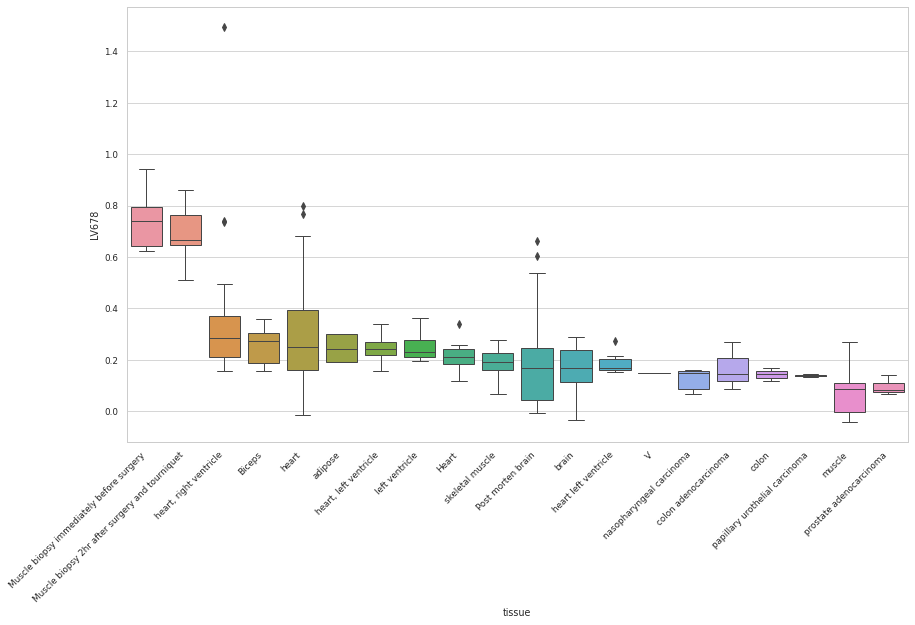

array(['SRP055569', 'SRP026315', 'SRP042161', 'SRP033135', 'SRP014428',
       'SRP062177', 'SRP044206', 'SRP057196', 'SRP060416', 'SRP049500',
       'SRP006575', 'SRP012461', 'SRP007947'], dtype=object)

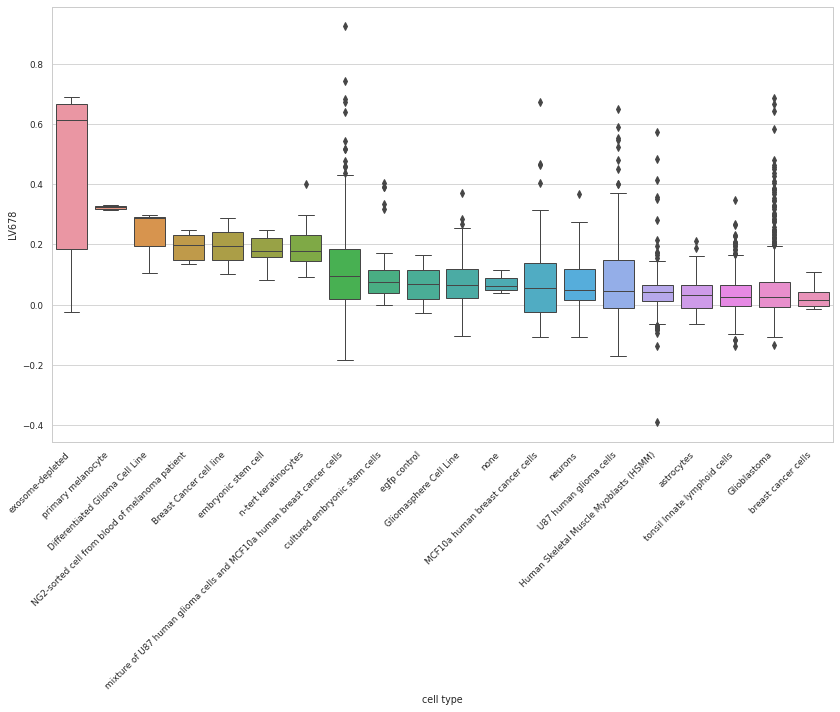

array(['SRP036821'], dtype=object)

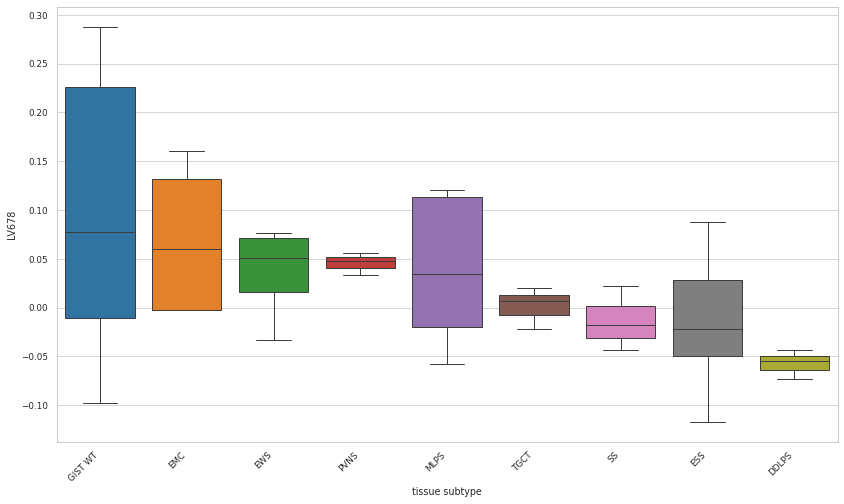

,pathway,LV index,AUC,p-value,FDR


SRP024268, SRP007947, SRP064464, SRP057196, SRP066834, SRP055569, SRP060416, SRP007412, SRP041036, SRP029889, SRP042161, SRP058667, SRP039361, SRP060355, SRP007338, SRP045276, SRP015976, SRP028336, SRP056696, SRP042620, SRP014428, SRP055513, SRP063840, SRP006575, SRP050499, SRP012015, SRP061701, SRP045569, SRP033135, SRP047192, SRP059066, SRP063834, SRP058773, SRP037982, SRP064259, SRP017138, SRP059379, SRP041826, SRP050003, SRP020493, SRP050551, SRP010483, SRP012461, SRP035387, SRP039694, SRP001558, SRP009247, SRP011924, SRP066956, SRP040998, SRP056098, SRP052740, SRP058626, SRP034712, SRP062873, SRP004837, SRP025982, SRP042218, SRP051688, SRP063661, SRP049591, SRP009373, SRP003901, SRP043960, SRP045898, SRP056395, SRP030617, SRP007461, SRP066356, SRP051485, SRP045659, SRP011546, SRP050992, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (71 != 73)
  warnings.warn(


''

30210_raw-Eosinophill_percentage                                                                                                                               4.402451
eosinophil count                                                                                                                                               4.310983
E4_DM2NOCOMP-Type_2_diabetes_without_complications                                                                                                             3.948016
sum of eosinophil and basophil counts                                                                                                                          3.749570
22601_11813097-Job_coding_hospital_manager_health_service_manager_clinical_manager_nursing_service_manager                                                     3.688957
20003_1140871052-Treatmentmedication_code_calcium_carbonatecholecalciferol_125g5micrograms_tablet                                                              3

''

,gene_name,LV470,gene_band
0,SLC5A2,7.108951,16p11.2
1,EHHADH,6.455047,3q27.2
2,PCCA,5.499965,13q32.3
3,CYP4F3,5.326694,19p13.12
4,SERPINF2,5.129304,17p13.3
5,AIFM1,4.748060,NaN
6,GOSR1,4.529826,17q11.2
7,NEURL3,4.529236,2q11.2
8,LDHD,4.385765,16q23.1
9,PATZ1,4.366936,22q12.2


tissue            0.087744
tissue type       0.010720
tissue subtype    0.010720
cell type         0.001093
cell subtype      0.000645
dtype: float64

array(['SRP024268', 'SRP057196', 'SRP066834', 'SRP029889', 'SRP060355',
       'SRP045276', 'SRP028336', 'SRP056696', 'SRP042620', 'SRP014428',
       'SRP055513', 'SRP006575', 'SRP047192', 'SRP037982', 'SRP050003',
       'SRP050551', 'SRP010483', 'SRP039694', 'SRP001558', 'SRP011924',
       'SRP058626', 'SRP004837', 'SRP042218', 'SRP009373', 'SRP003901',
       'SRP045898', 'SRP011546'], dtype=object)

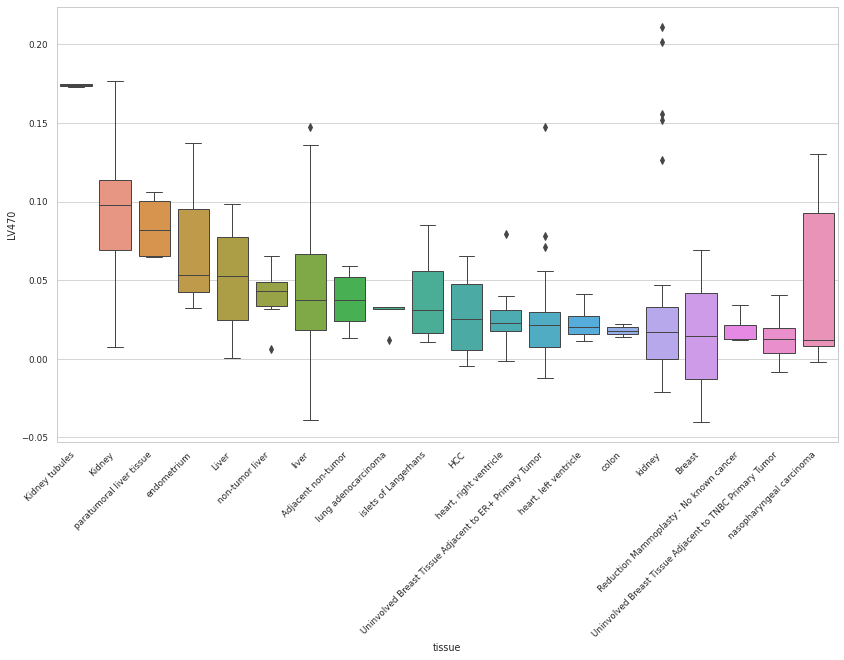

array(['SRP058667'], dtype=object)

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:430: UserWarning: Single value for tissue type: 0.0248172962017353
  warnings.warn(f"Single value for {imp_f}: {cat_order}")


array(['SRP058667'], dtype=object)

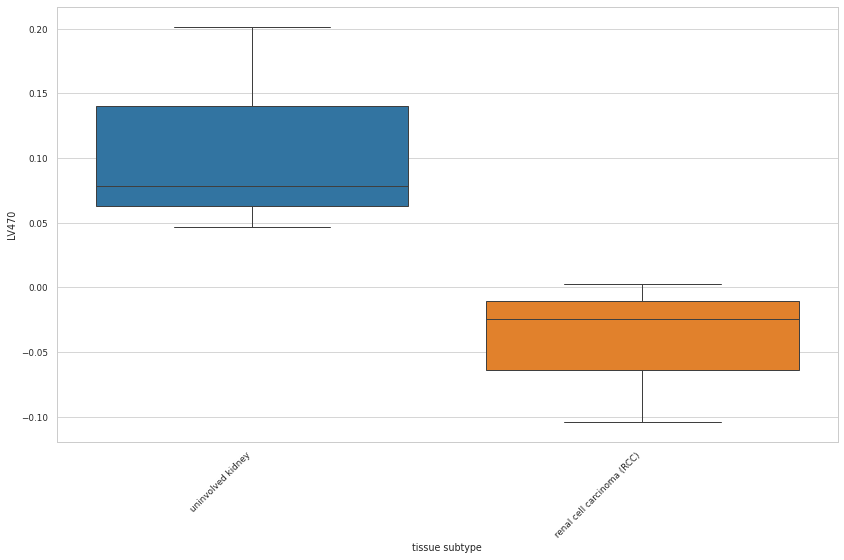

array(['SRP007947', 'SRP057196', 'SRP055569', 'SRP060416', 'SRP042161',
       'SRP039361', 'SRP015976', 'SRP014428', 'SRP063840', 'SRP006575',
       'SRP012015', 'SRP045569', 'SRP033135', 'SRP047192', 'SRP059066',
       'SRP063834', 'SRP064259', 'SRP059379', 'SRP041826', 'SRP050003',
       'SRP020493', 'SRP012461', 'SRP035387', 'SRP052740', 'SRP058626',
       'SRP062873', 'SRP004837', 'SRP042218', 'SRP051688', 'SRP009373',
       'SRP066356', 'SRP011546', 'SRP050992'], dtype=object)

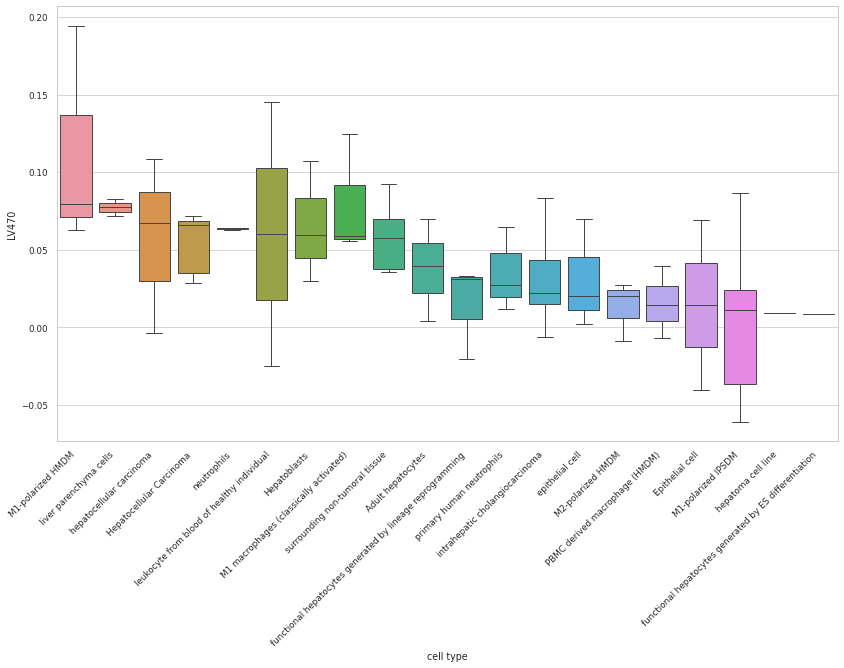

array(['SRP063661'], dtype=object)

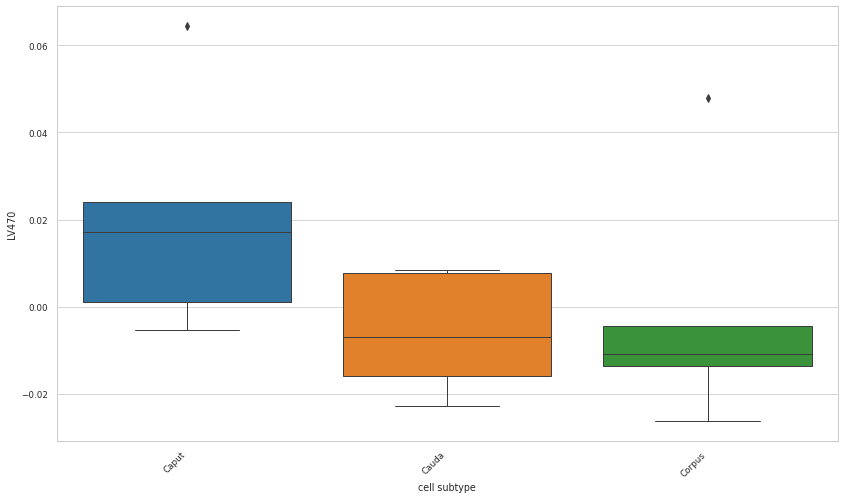

,pathway,LV index,AUC,p-value,FDR
316,REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS,66,0.615625,0.000024,0.000312


SRP048674, SRP029207, SRP021912, SRP051249, SRP040292, SRP055513, SRP055569, SRP057196, SRP050499, SRP017959, SRP029334, SRP045364, SRP043434, SRP049981, SRP042161, SRP008218, SRP020646, SRP011895, SRP012461, SRP021193, SRP012656, SRP026052, SRP050954, SRP037982, SRP049946, SRP027383, SRP022259, SRP049409, SRP056696, SRP018933, SRP002915, SRP033135, SRP009123, SRP058804, SRP043221, SRP066834, SRP050193, SRP048759, SRP047192, SRP050551, SRP008145, SRP060416, SRP044610, SRP050992, SRP004637, SRP044668, SRP057205, SRP058773, SRP042218, SRP016059, SRP058740, SRP040300, SRP020493, SRP039694, SRP040998, SRP058375, SRP056146, SRP010054, SRP039591, SRP019994, SRP014790, SRP014213, SRP007338, SRP029262, SRP014809, SRP018403, SRP041538, SRP063834, SRP034592, SRP018838, SRP007494, SRP050374, SRP002326, SRP007481, SRP030617, SRP026620, SRP052879, SRP015013, SRP033351, SRP058626, SRP061566, SRP039338, SRP017435, SRP044042, SRP015853, SRP007461, SRP007498, SRP003726, SRP066371, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (86 != 89)
  warnings.warn(


''

L12_HYPERTROPHICNAS-Other_and_unspecified_hypertrophic_disorders_of_skin                                                                                                      4.462269
L12_HYPERTROPHICSKIN-Hypertrophic_disorders_of_skin                                                                                                                           4.072287
100630-Rose_wine_intake                                                                                                                                                       3.963270
102360-Sweet_biscuits_intake                                                                                                                                                  3.868189
22601_62213359-Job_coding_hairdresser_barber_shampooist_hair_stylist                                                                                                          3.389067
22601_32293082-Job_coding_other_therapist_including_acupuncturist_aromatherapist_diet

''

,gene_name,LV66,gene_band
0,DHCR24,7.216010,1p32.3
1,SLC47A1,6.877400,17p11.2
2,HSD11B1,5.555764,1q32.2
3,SCARB1,5.109801,12q24.31
4,IL6ST,4.310095,5q11.2
5,DPYSL3,3.964287,5q32
6,PORCN,3.641519,NaN
7,PRKX,3.640764,NaN
8,RHOU,3.382568,1q42.13
9,GREB1,3.309886,2p25.1


cell type      0.049005
tissue         0.008016
tissue type    0.000788
dtype: float64

array(['SRP048674', 'SRP021912', 'SRP055569', 'SRP057196', 'SRP045364',
       'SRP049981', 'SRP042161', 'SRP008218', 'SRP012461', 'SRP050954',
       'SRP022259', 'SRP049409', 'SRP018933', 'SRP033135', 'SRP058804',
       'SRP048759', 'SRP047192', 'SRP060416', 'SRP044610', 'SRP050992',
       'SRP042218', 'SRP016059', 'SRP020493', 'SRP056146', 'SRP014213',
       'SRP063834', 'SRP007494', 'SRP050374', 'SRP026620', 'SRP052879',
       'SRP033351', 'SRP058626', 'SRP061566', 'SRP015853', 'SRP003726',
       'SRP066371'], dtype=object)

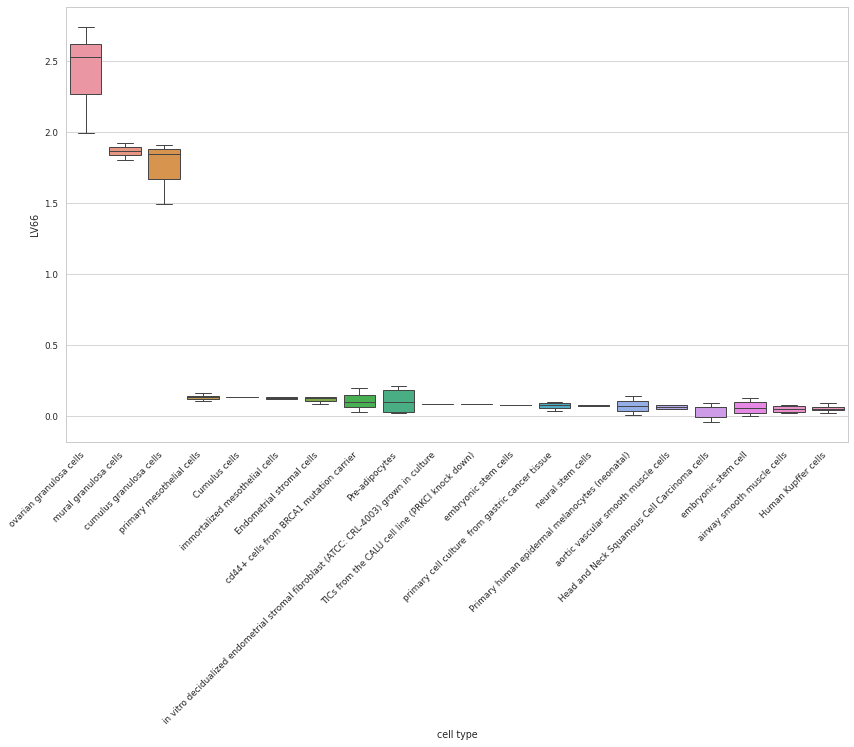

array(['SRP029207', 'SRP040292', 'SRP055513', 'SRP057196', 'SRP043434',
       'SRP008218', 'SRP021193', 'SRP037982', 'SRP056696', 'SRP018933',
       'SRP009123', 'SRP043221', 'SRP066834', 'SRP048759', 'SRP047192',
       'SRP050551', 'SRP004637', 'SRP042218', 'SRP016059', 'SRP058740',
       'SRP039694', 'SRP039591', 'SRP019994', 'SRP029262', 'SRP041538',
       'SRP034592', 'SRP007494', 'SRP002326', 'SRP007481', 'SRP033351',
       'SRP058626', 'SRP039338', 'SRP003726'], dtype=object)

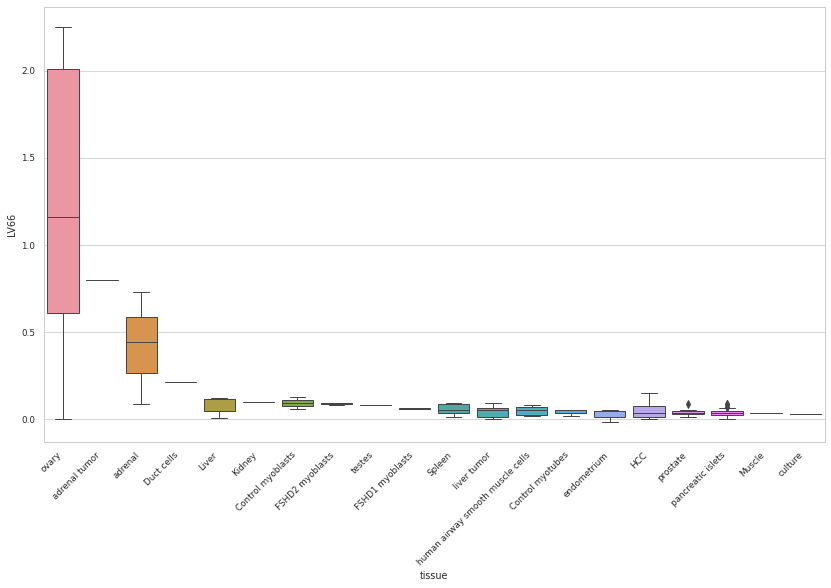

array(['SRP012656', 'SRP044668'], dtype=object)

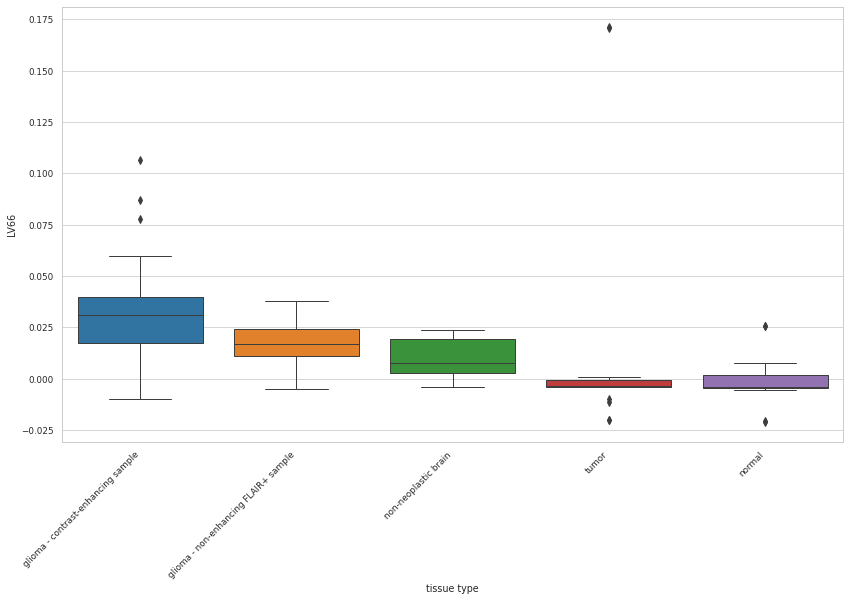

,pathway,LV index,AUC,p-value,FDR


SRP037775, SRP064259, SRP033250, SRP026537, SRP045322, SRP042620, SRP042161, SRP055569, SRP049500, SRP006575, SRP030475, SRP011974, SRP049507, SRP030401, SRP043470, SRP057205, SRP061241, SRP055512, SRP059379, SRP058722, SRP063620, SRP049988, SRP019498, SRP060416, SRP057196, SRP065202, SRP033135, SRP018853, SRP011054, SRP019936, SRP013389, SRP063840, SRP066834, SRP032789, SRP048664, SRP040966, SRP047192, SRP061243, SRP004637, SRP012557, SRP040418, SRP023262, SRP044610, SRP058571, SRP055153, SRP051102, SRP031503, SRP058773, SRP012167, SRP043320, SRP035988, SRP067214, SRP049713, SRP040505, SRP050971, SRP057758, SRP013239, SRP029334, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (56 != 58)
  warnings.warn(


''

sum of basophil and neutrophil counts                                                                   7.812599
neutrophil count                                                                                        7.782137
granulocyte count                                                                                       7.717013
sum of neutrophil and eosinophil counts                                                                 7.680676
myeloid white cell count                                                                                7.336095
30140_raw-Neutrophill_count                                                                             6.657680
3786_raw-Age_asthma_diagnosed                                                                           6.580418
leukocyte count                                                                                         6.457372
1717-Skin_colour                                                                                

''

,gene_name,LV189,gene_band
0,TCN1,7.445036,11q12.1
1,ALDH3B2,4.980042,11q13.2
2,MED1,4.384997,17q12
3,PSMD3,4.113116,17q21.1
4,CDK12,2.875934,17q12
5,RPL19,2.807342,17q12
6,PIP4K2B,2.794035,17q12
7,ERBB2,2.676997,17q12
8,MED24,2.188042,17q21.1
9,PIGO,1.995728,9p13.3


cell type       0.033189
tissue          0.003374
cell subtype    0.001682
tissue type     0.001054
dtype: float64

array(['SRP037775', 'SRP064259', 'SRP026537', 'SRP045322', 'SRP042161',
       'SRP055569', 'SRP049500', 'SRP006575', 'SRP049507', 'SRP055512',
       'SRP059379', 'SRP063620', 'SRP049988', 'SRP019498', 'SRP060416',
       'SRP057196', 'SRP065202', 'SRP033135', 'SRP011054', 'SRP063840',
       'SRP040966', 'SRP047192', 'SRP040418', 'SRP044610', 'SRP058571',
       'SRP055153', 'SRP051102', 'SRP031503', 'SRP049713', 'SRP040505',
       'SRP057758'], dtype=object)

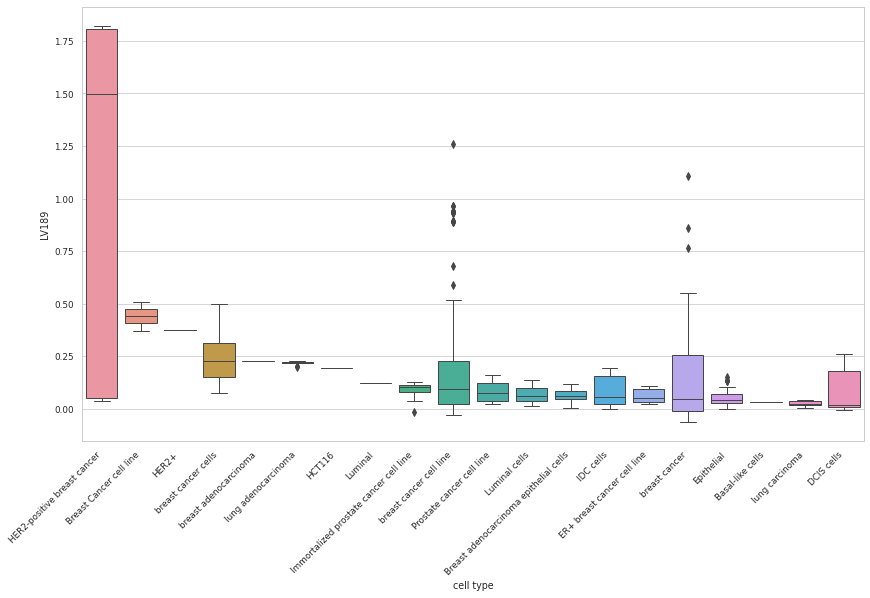

array(['SRP042620', 'SRP006575', 'SRP043470', 'SRP061241', 'SRP058722',
       'SRP057196', 'SRP066834', 'SRP047192', 'SRP061243', 'SRP004637',
       'SRP023262', 'SRP012167', 'SRP043320'], dtype=object)

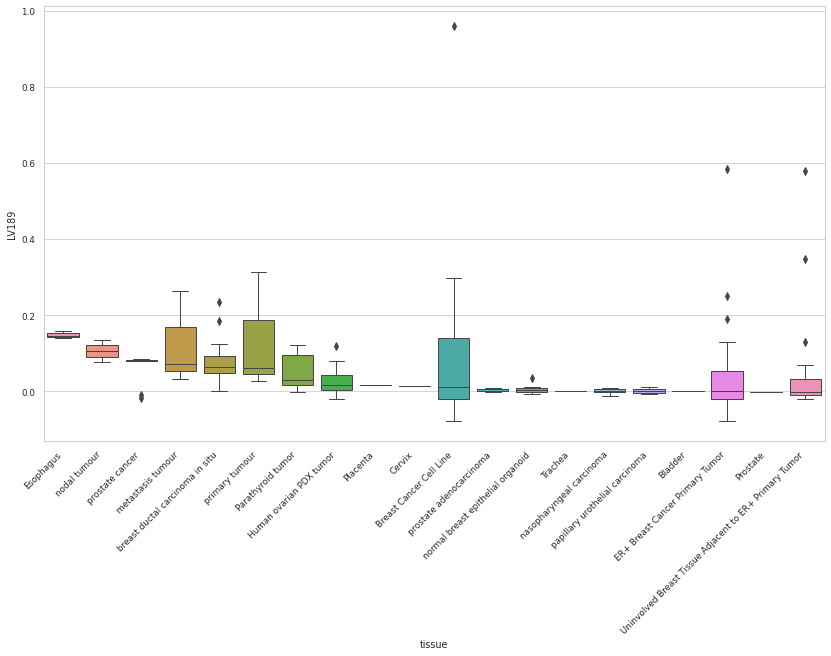

array(['SRP040418'], dtype=object)

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:430: UserWarning: Single value for cell subtype: 0.04152523889635197
  warnings.warn(f"Single value for {imp_f}: {cat_order}")


array(['SRP019936', 'SRP035988', 'SRP050971'], dtype=object)

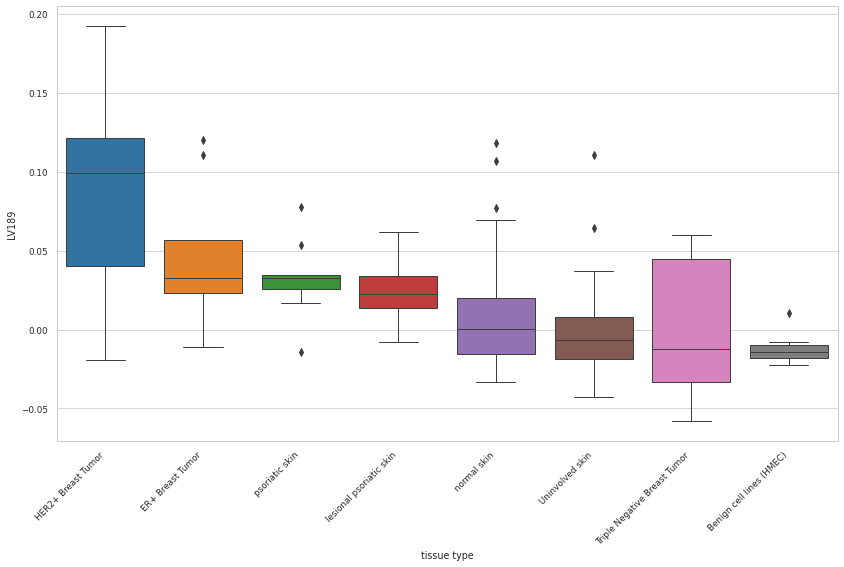

,pathway,LV index,AUC,p-value,FDR
1367,REACTOME_SIGNALING_BY_EGFR_IN_CANCER,517,0.679463,0.001198,0.008909


SRP055569, SRP057196, SRP015449, SRP002326, SRP042161, SRP060416, SRP033206, SRP030401, SRP025989, SRP050892, SRP040421, SRP012461, SRP064259, SRP050499, SRP009266, SRP018104, SRP005279, SRP066834, SRP006970, SRP057205, SRP029889, SRP019994, SRP018020, SRP043960, SRP009862, SRP017199, SRP058773, SRP014624, SRP018838, SRP015976, SRP060359, SRP014867, SRP033119, SRP059775, SRP014320, SRP063840, SRP041788, SRP056696, SRP017575, SRP018719, SRP027345, SRP017933, SRP046266, SRP030617, SRP015670, SRP015013, SRP044206, SRP017190, SRP055863, SRP011422, SRP007338, SRP015678, SRP045639, SRP006575, SRP028325, SRP033135, SRP059039, SRP004837, SRP059732, SRP062389, SRP059379, SRP014428, SRP002605, SRP023262, SRP027258, SRP036821, SRP010038, SRP038964, SRP041162, SRP014027, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (67 != 70)
  warnings.warn(


''

6162_4-Types_of_transport_used_excluding_work_Cycle                                                                                   5.115286
lymphocyte count                                                                                                                      3.902658
hemiplegia                                                                                                                            3.759837
5992-ECG_phase_duration                                                                                                               3.711403
5993-ECG_number_of_stages_in_a_phase                                                                                                  3.627607
friendship satisfaction measurement                                                                                                   3.617477
30120_raw-Lymphocyte_count                                                                                                            3.572626

''

,gene_name,LV517,gene_band
0,CDC37,8.367113,19p13.2
1,SORBS3,6.602325,8p21.3
2,SF3B2,5.678155,11q13.1
3,SOD1,3.144710,21q22.11
4,HSP90AA1,3.068166,14q32.31
5,SMC1A,2.761089,NaN
6,ALDH3A2,2.452712,17p11.2
7,RTN4,2.332941,2p16.1
8,PCBD1,1.937810,10q22.1
9,AARS,1.537680,16q22.1


cell type         0.024904
tissue            0.000649
tissue subtype    0.000441
dtype: float64

array(['SRP055569', 'SRP057196', 'SRP042161', 'SRP060416', 'SRP012461',
       'SRP064259', 'SRP005279', 'SRP006970', 'SRP017199', 'SRP015976',
       'SRP063840', 'SRP015670', 'SRP044206', 'SRP017190', 'SRP045639',
       'SRP006575', 'SRP033135', 'SRP004837', 'SRP059379', 'SRP014428',
       'SRP027258', 'SRP010038', 'SRP038964', 'SRP014027'], dtype=object)

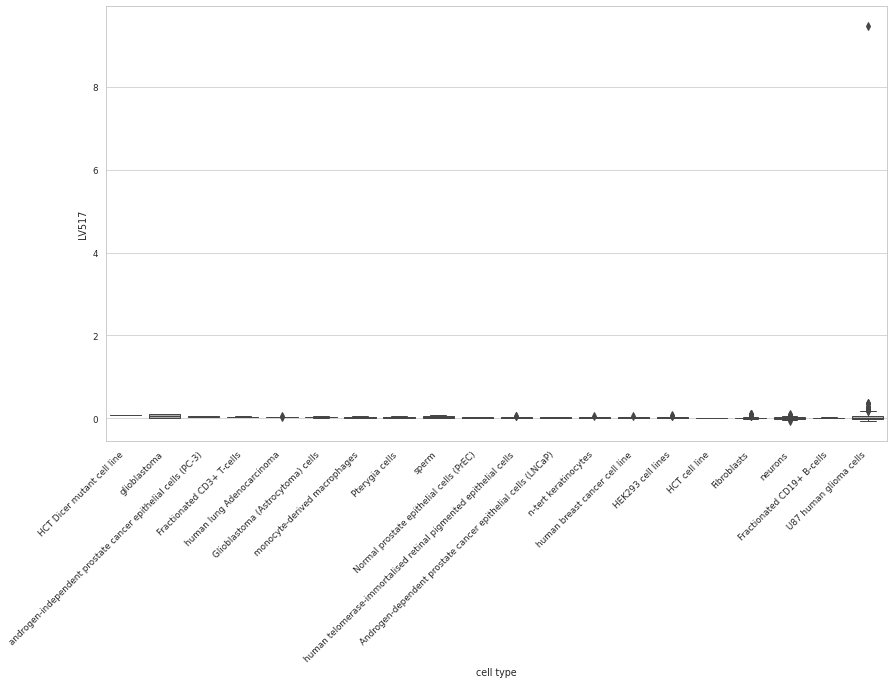

array(['SRP057196', 'SRP002326', 'SRP005279', 'SRP066834', 'SRP029889',
       'SRP019994', 'SRP056696', 'SRP017575', 'SRP017933', 'SRP055863',
       'SRP011422', 'SRP015678', 'SRP006575', 'SRP059039', 'SRP004837',
       'SRP014428', 'SRP023262', 'SRP036821'], dtype=object)

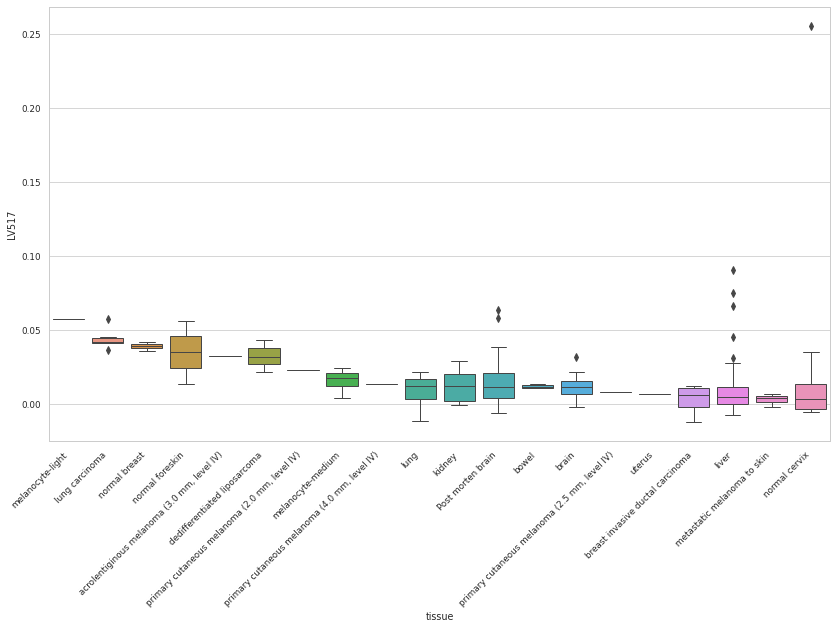

array(['SRP036821'], dtype=object)

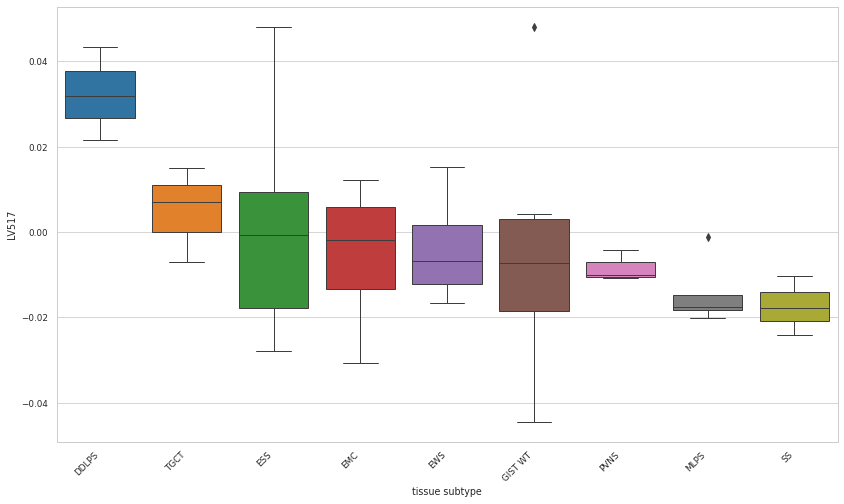

,pathway,LV index,AUC,p-value,FDR
1879,REACTOME_MITOCHONDRIAL_PROTEIN_IMPORT,840,0.850471,0.000041,0.000520
1881,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,840,0.739287,0.000047,0.000578
1884,REACTOME_TRNA_AMINOACYLATION,840,0.733583,0.006690,0.033956
1885,MIPS_SPLICEOSOME,840,0.745691,0.000001,0.000024
1886,MIPS_39S_RIBOSOMAL_SUBUNIT_MITOCHONDRIAL,840,0.820899,0.000156,0.001621


SRP043417, SRP028301, SRP059775, SRP062177, SRP012056, SRP033119, SRP040278, SRP058300, SRP034543, SRP056084, SRP038695, SRP058841, SRP059948, SRP042161, SRP009266, SRP006475, SRP045501, SRP033369, SRP058773, SRP018861, SRP041036, SRP055810, SRP055569, SRP029245, SRP018719, SRP015964, SRP014867, SRP010280, SRP048536, SRP002605, SRP053402, SRP063339, SRP019250, SRP007461, SRP044653, SRP046749, SRP039397, SRP052950, SRP056036, SRP043962, SRP061539, SRP019989, SRP064481, SRP045481, SRP028887, SRP013725, SRP009861, SRP041263, SRP058087, SRP019241, SRP050055, SRP011546, SRP039348, SRP010430, SRP058191, SRP049510, SRP056200, SRP060637, SRP021214, SRP060416, SRP041656, SRP064464, SRP041396, SRP053052, SRP029515, SRP064317, SRP001349, SRP041130, SRP017644, SRP059266, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (68 != 70)
  warnings.warn(


''

1488_raw-Tea_intake                                                                                                 4.570165
30140_raw-Neutrophill_count                                                                                         3.520659
XVII_MALFORMAT_ABNORMAL-Congenital_malformations_deformations_and_chromosomal_abnormalities                         3.181926
2887-Number_of_cigarettes_previously_smoked_daily                                                                   3.155120
22617_5113-Job_SOC_coding_Gardeners_and_groundsmengroundswomen                                                      3.153329
neutrophil count                                                                                                    3.094930
20003_2038459704-Treatmentmedication_code_carbamazepine                                                             3.035843
22601_51132488-Job_coding_gardener_groundsmangroundswoman_park_keeper_landscape_gardener_greenkeeper_turf_cutter    3.002729


''

,gene_name,LV840,gene_band
0,SNRPB,2.563358,20p13
1,EIF4A3,2.223462,17q25.3
2,GEMIN4,2.219158,17p13.3
3,MRPL37,2.028093,1p32.3
4,MRPL12,2.011655,17q25.3
5,PRMT5,1.875782,14q11.2
6,WDR77,1.821151,1p13.2
7,MRPS2,1.808959,9q34.3
8,C1QBP,1.781616,17p13.2
9,PSME3,1.778598,NaN


cell type    0.014267
tissue       0.011508
dtype: float64

array(['SRP062177', 'SRP040278', 'SRP034543', 'SRP056084', 'SRP042161',
       'SRP055569', 'SRP019250', 'SRP046749', 'SRP061539', 'SRP058087',
       'SRP019241', 'SRP011546', 'SRP010430', 'SRP056200', 'SRP021214',
       'SRP060416', 'SRP053052', 'SRP017644'], dtype=object)

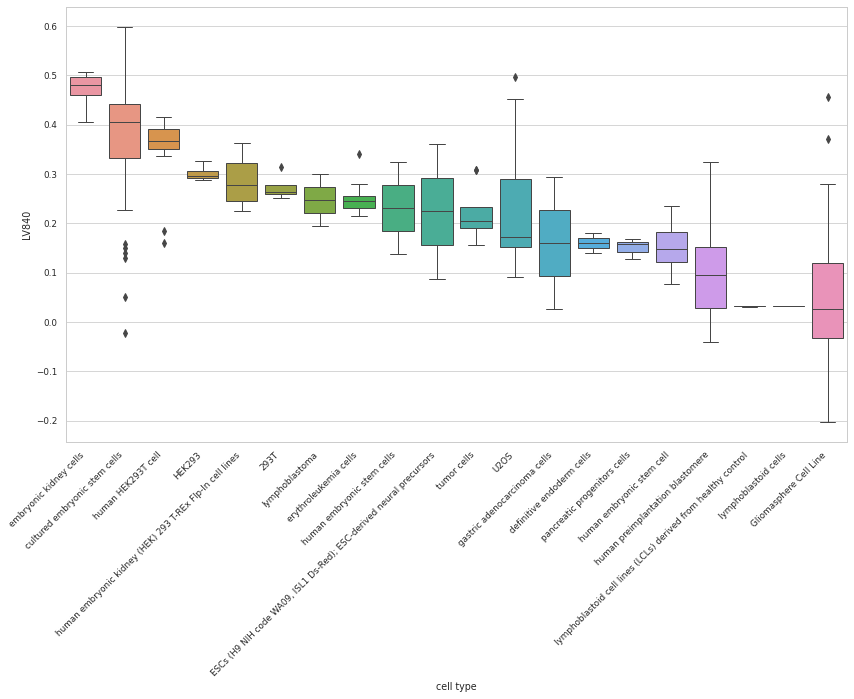

array(['SRP052950', 'SRP011546', 'SRP039348', 'SRP029515'], dtype=object)

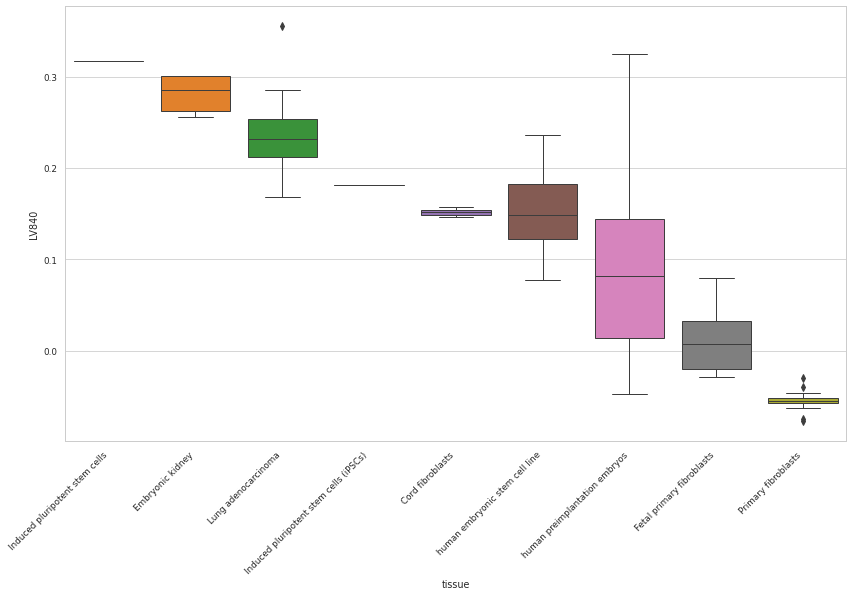

,pathway,LV index,AUC,p-value,FDR
887,REACTOME_TRIGLYCERIDE_BIOSYNTHESIS,246,0.857366,5.437536e-05,6.515981e-04
888,KEGG_PYRUVATE_METABOLISM,246,0.817668,2.905798e-04,2.655850e-03
889,REACTOME_FATTY_ACID_TRIACYLGLYCEROL_AND_KETONE...,246,0.890091,2.762125e-18,3.971936e-16
890,KEGG_PROPANOATE_METABOLISM,246,0.828621,4.947481e-04,4.268686e-03
891,REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS,246,0.671159,3.216205e-10,1.137271e-08


SRP042186, SRP045545, SRP044756, SRP051211, SRP042620, SRP055749, SRP029899, SRP021478, SRP042086, SRP065812, SRP007412, SRP020470, SRP037778, SRP042161, SRP029889, SRP057196, SRP053101, SRP050499, SRP035988, SRP033135, SRP034712, SRP012461, SRP056041, SRP048674, SRP059643, SRP045364, SRP026042, SRP050971, SRP051705, SRP035387, SRP055512, SRP007461, SRP065451, SRP007338, SRP019936, SRP055569, SRP060355, SRP058571, SRP041377, SRP040998, SRP059379, SRP036133, SRP066834, SRP051772, SRP044056, SRP048669, SRP059066, SRP068078, SRP060359, SRP055475, SRP058771, SRP045639, SRP043085, SRP062177, SRP064464, SRP041597, SRP056696, SRP059035, SRP010678, SRP049593, SRP048536, SRP061566, SRP030617, SRP057804, SRP045156, SRP044171, SRP010644, SRP057448, SRP041751, SRP061701, SRP033131, SRP041387, SRP063834, SRP020493, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (72 != 74)
  warnings.warn(


''

30100_raw-Mean_platelet_thrombocyte_volume                                                                              6.632557
MAGNETIC_CH2.DB.ratio                                                                                                   6.584225
1747_2-Hair_colour_natural_before_greying_Red                                                                           6.287111
3143_raw-Ankle_spacing_width                                                                                            5.119107
hypercholesterolemia                                                                                                    4.991051
4119_raw-Ankle_spacing_width_right                                                                                      4.822150
20095_3-Size_of_white_wine_glass_drunk_large_250ml                                                                      4.490390
1727-Ease_of_skin_tanning                                                                        

''

,gene_name,LV246,gene_band
0,SCD,6.672060,10q24.31
1,ACSS2,6.258514,20q11.22
2,GPAM,5.714077,10q25.2
3,DGAT2,4.738347,11q13.5
4,ACLY,3.708678,17q21.2
5,GPD1,3.346001,12q13.12
6,MVD,3.320598,16q24.2
7,FASN,2.915241,17q25.3
8,LPL,2.858278,8p21.3
9,ACSL1,2.682199,4q35.1


cell type      0.028771
tissue         0.013640
tissue type    0.008186
dtype: float64

array(['SRP042186', 'SRP045545', 'SRP044756', 'SRP051211', 'SRP042161',
       'SRP057196', 'SRP033135', 'SRP012461', 'SRP048674', 'SRP045364',
       'SRP035387', 'SRP055512', 'SRP065451', 'SRP055569', 'SRP058571',
       'SRP059379', 'SRP036133', 'SRP051772', 'SRP044056', 'SRP048669',
       'SRP059066', 'SRP045639', 'SRP043085', 'SRP062177', 'SRP059035',
       'SRP010678', 'SRP061566', 'SRP057804', 'SRP010644', 'SRP041751',
       'SRP063834', 'SRP020493'], dtype=object)

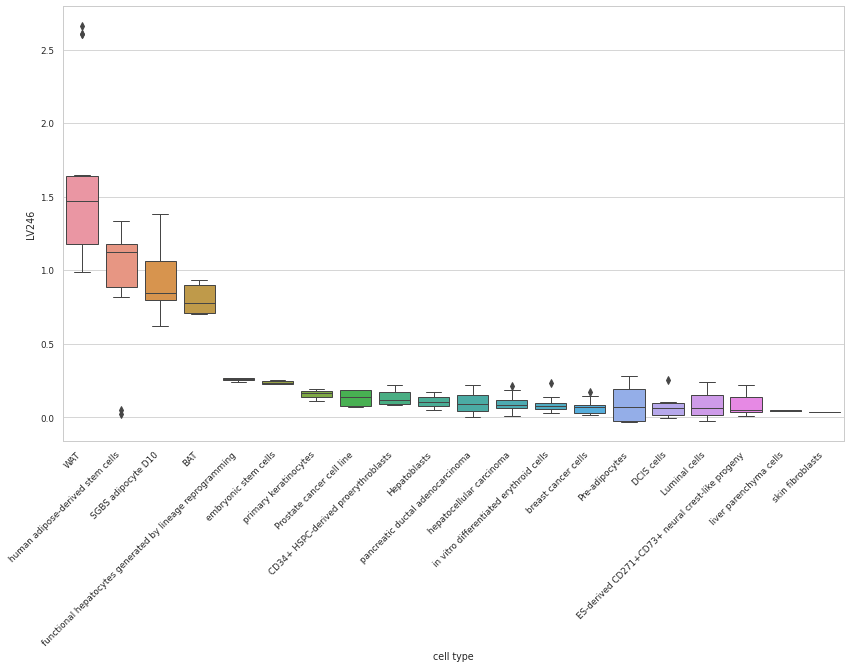

array(['SRP042620', 'SRP055749', 'SRP029899', 'SRP021478', 'SRP042086',
       'SRP029889', 'SRP057196', 'SRP056041', 'SRP026042', 'SRP060355',
       'SRP066834', 'SRP044056', 'SRP043085', 'SRP041597', 'SRP056696',
       'SRP041387'], dtype=object)

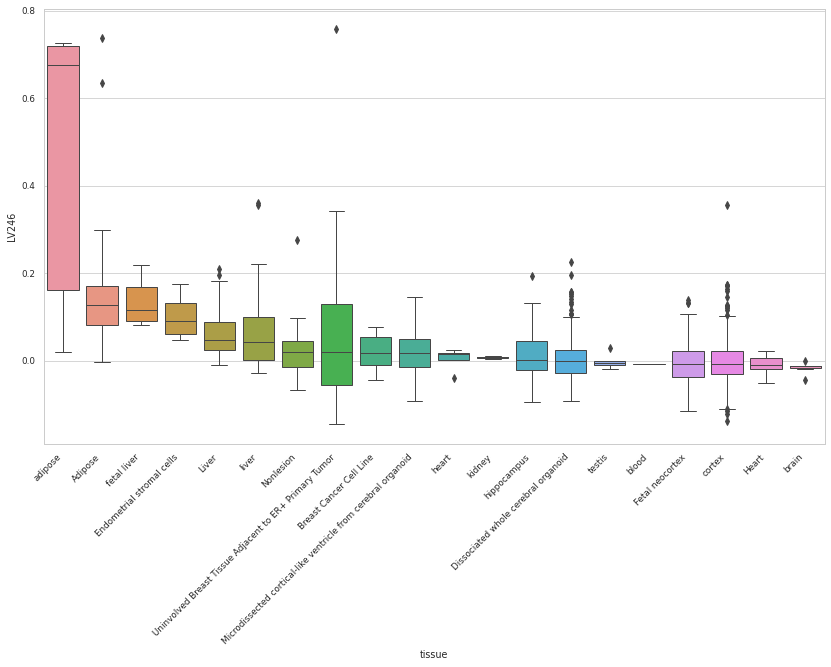

array(['SRP065812', 'SRP035988', 'SRP050971', 'SRP019936'], dtype=object)

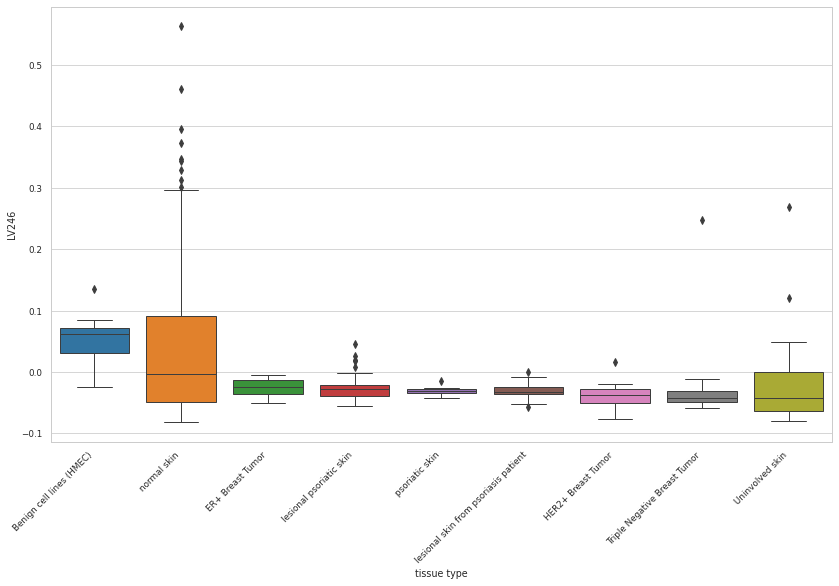

,pathway,LV index,AUC,p-value,FDR


SRP012461, SRP055569, SRP042161, SRP060416, SRP042218, SRP014624, SRP057196, SRP015678, SRP015449, SRP011054, SRP031776, SRP033369, SRP066834, SRP011578, SRP057205, SRP059170, SRP025982, SRP002915, SRP057248, SRP011546, SRP055810, SRP050179, SRP033135, SRP056696, SRP029334, SRP058773, SRP067529, SRP063620, SRP041718, SRP050499, SRP005279, SRP041094, SRP013984, SRP002640, SRP058120, SRP019994, SRP059531, SRP003754, SRP035391, SRP042184, SRP040243, SRP018716, SRP048674, SRP051000, SRP007461, SRP063840, SRP017575, SRP026537, SRP057500, SRP047192, SRP030617, SRP008554, SRP064259, SRP030475, SRP014867, SRP039348, SRP044206, SRP010038, SRP059035, SRP059732, SRP019936, SRP037982, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (59 != 62)
  warnings.warn(


''

ankylosing spondylitis                                            9.561404
celiac disease                                                    6.806596
rheumatoid arthritis                                              5.184882
psoriasis                                                         5.181921
2986-Started_insulin_within_one_year_diagnosis_of_diabetes        4.903962
malabsorption syndrome                                            4.183900
20003_1141191044-Treatmentmedication_code_levothyroxine_sodium    4.114556
hypothyroidism AND myxedema                                       4.024776
K11_COELIAC-Coeliac_disease                                       4.002400
systemic lupus erythematosus                                      3.867643
psoriatic arthritis                                               3.727283
6144_3-Never_eat_eggs_dairy_wheat_sugar_Wheat_products            3.700861
lymphocyte count                                                  3.562833
hyperthyroidism AND thyro

''

,gene_name,LV502,gene_band
0,MICA,7.641894,6p21.33
1,NDUFB9,5.530403,8q24.13
2,ALAD,5.231627,9q32
3,YIPF6,4.524568,NaN
4,FPGS,4.282031,9q34.11
5,LYAR,4.266996,4p16.3
6,GAS6,3.119890,13q34
7,ATP5G1,2.745887,17q21.32
8,CANT1,2.413621,17q25.3
9,PRKCB,2.367444,16p12.2


cell type         0.027088
tissue            0.000908
cell line/type    0.000666
tissue type       0.000209
dtype: float64

array(['SRP012461', 'SRP055569', 'SRP042161', 'SRP060416', 'SRP042218',
       'SRP057196', 'SRP011054', 'SRP011578', 'SRP059170', 'SRP011546',
       'SRP050179', 'SRP033135', 'SRP063620', 'SRP005279', 'SRP041094',
       'SRP059531', 'SRP048674', 'SRP051000', 'SRP063840', 'SRP026537',
       'SRP057500', 'SRP047192', 'SRP008554', 'SRP064259', 'SRP044206',
       'SRP010038', 'SRP059035'], dtype=object)

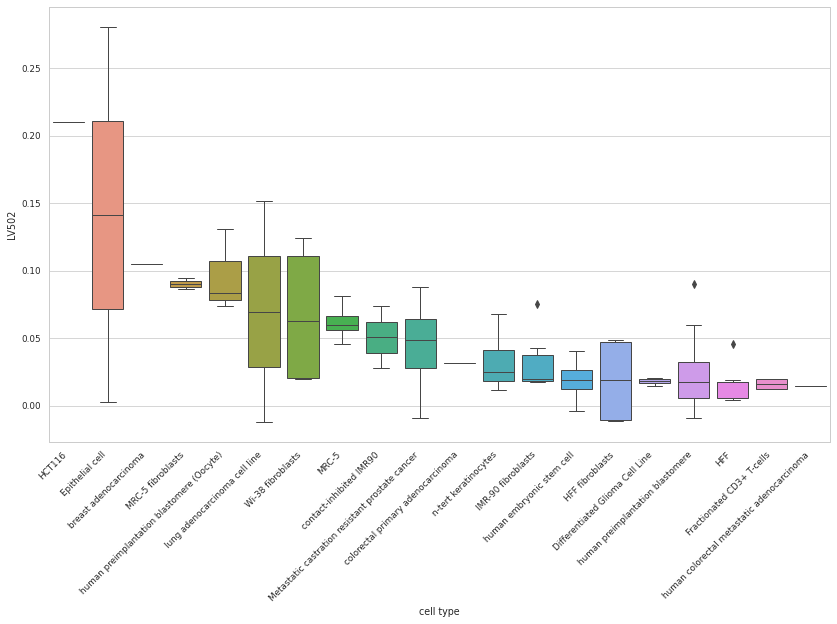

array(['SRP042218', 'SRP057196', 'SRP015678', 'SRP031776', 'SRP066834',
       'SRP059170', 'SRP011546', 'SRP056696', 'SRP005279', 'SRP002640',
       'SRP019994', 'SRP040243', 'SRP017575', 'SRP057500', 'SRP047192',
       'SRP039348', 'SRP037982'], dtype=object)

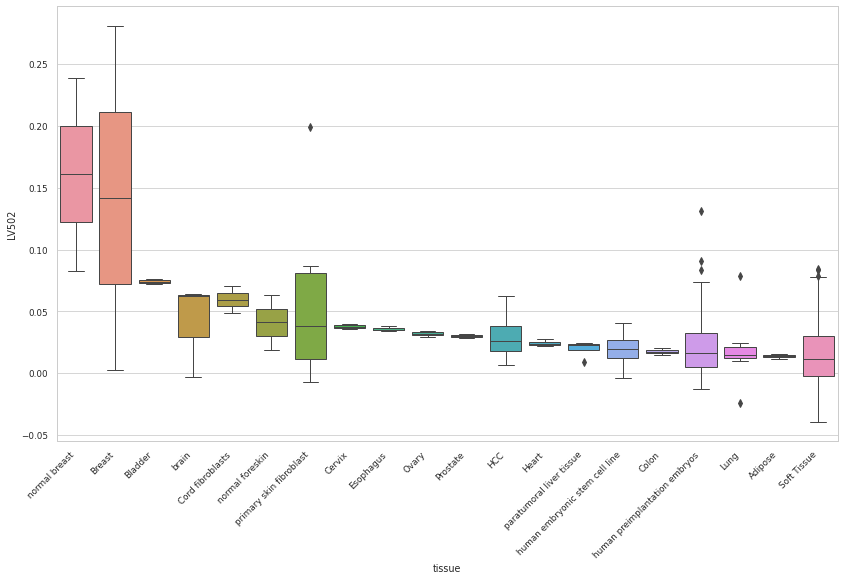

array(['SRP058120'], dtype=object)

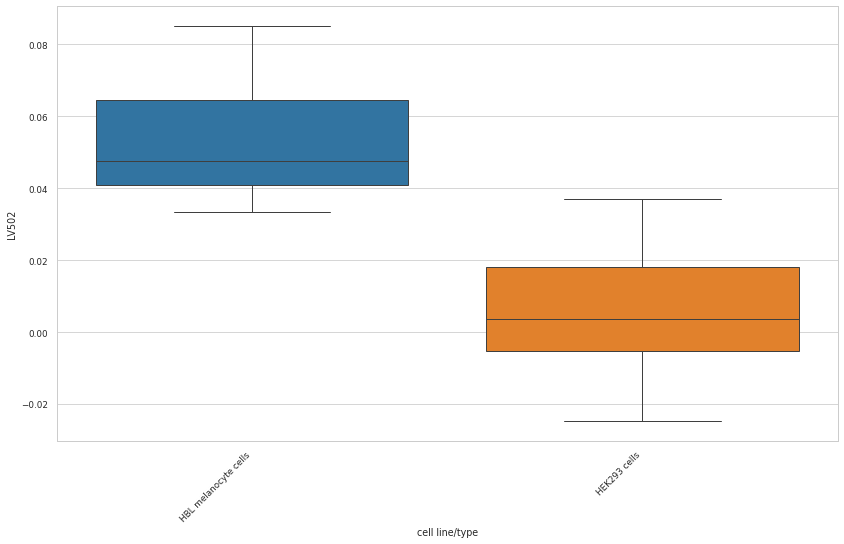

array(['SRP019936'], dtype=object)

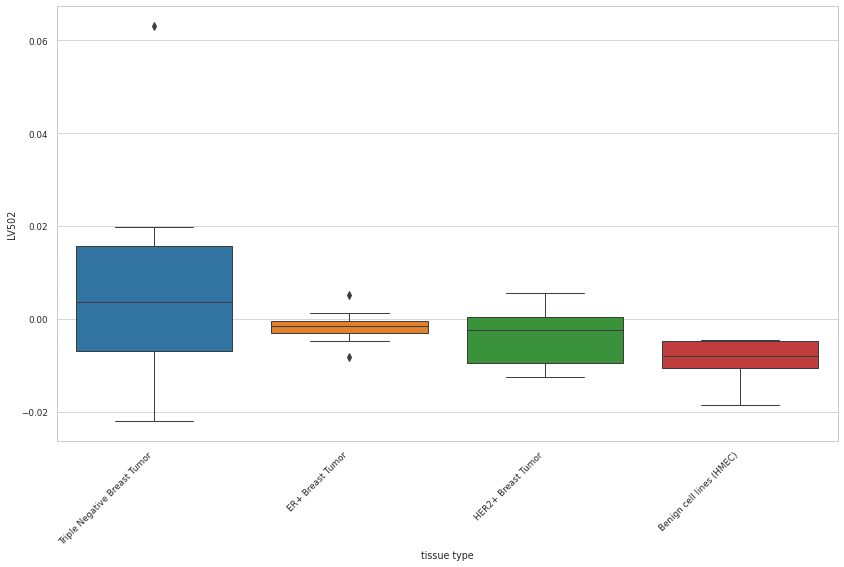

,pathway,LV index,AUC,p-value,FDR


SRP055569, SRP042161, SRP033135, SRP050499, SRP058773, SRP060416, SRP059775, SRP009266, SRP057196, SRP066834, SRP055153, SRP056696, SRP018838, SRP009862, SRP019994, SRP017575, SRP012461, SRP064464, SRP063840, SRP050551, SRP019936, SRP002326, SRP013402, SRP045573, SRP013363, SRP025982, SRP007338, SRP058626, SRP057205, SRP014428, SRP044917, SRP062177, SRP059035, SRP064259, SRP059379, SRP036053, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (34 != 36)
  warnings.warn(


''

30150-Eosinophill_count                                                                                                                                                 8.729055
eosinophil count                                                                                                                                                        8.355913
sum of eosinophil and basophil counts                                                                                                                                   8.340493
30210_raw-Eosinophill_percentage                                                                                                                                        7.845735
6152_8-Blood_clot_DVT_bronchitis_emphysema_asthma_rhinitis_eczema_allergy_diagnosed_by_doctor_Asthma                                                                    5.675746
asthma                                                                                                             

''

,gene_name,LV525,gene_band
0,RAD50,6.480460,5q31.1
1,GALK1,5.750150,17q25.1
2,PMM1,3.856636,22q13.2
3,PTPRK,3.616007,6q22.33
4,MLX,3.497898,17q21.2
5,ALG8,2.744826,11q14.1
6,CHMP2A,2.206550,19q13.43
7,POGLUT1,2.111735,3q13.33
8,PPP2R5E,2.081536,14q23.2
9,BLVRB,1.669616,19q13.2


cell type      0.020746
tissue         0.002386
tissue type    0.000554
dtype: float64

array(['SRP055569', 'SRP042161', 'SRP033135', 'SRP060416', 'SRP057196',
       'SRP055153', 'SRP012461', 'SRP063840', 'SRP013402', 'SRP058626',
       'SRP014428', 'SRP044917', 'SRP062177', 'SRP059035', 'SRP064259',
       'SRP059379'], dtype=object)

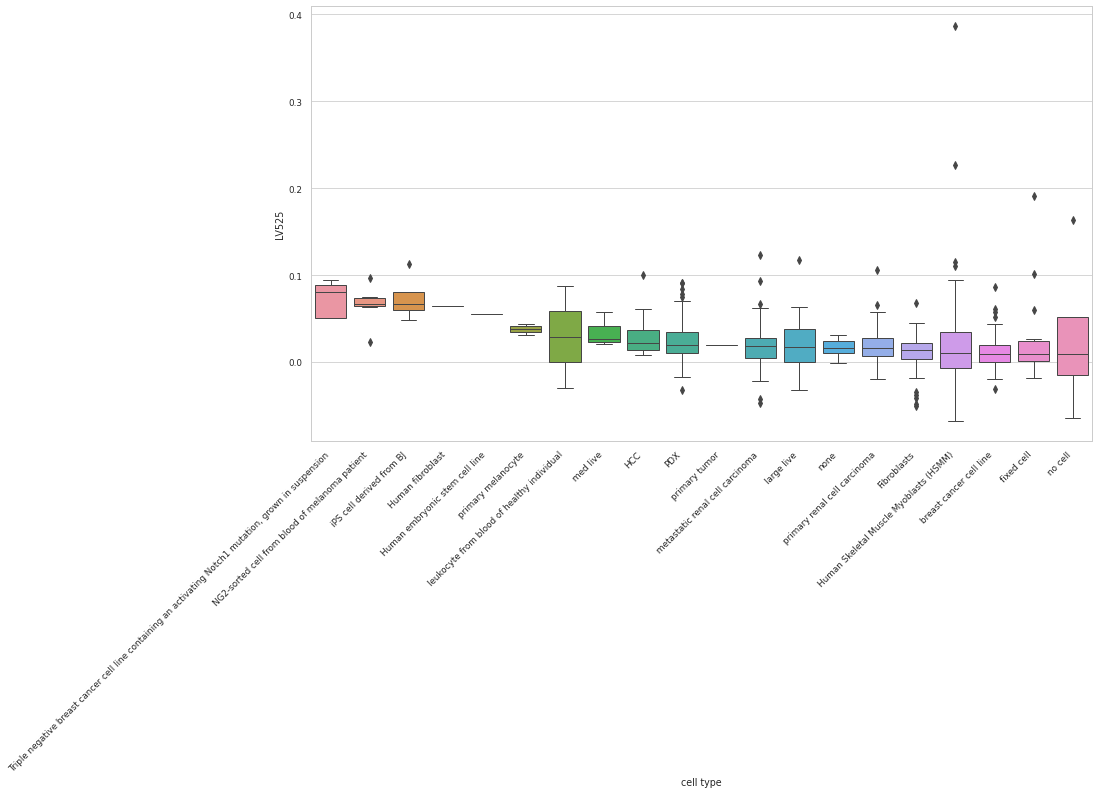

array(['SRP057196', 'SRP066834', 'SRP056696', 'SRP019994', 'SRP017575',
       'SRP050551', 'SRP002326', 'SRP045573', 'SRP058626', 'SRP014428',
       'SRP036053'], dtype=object)

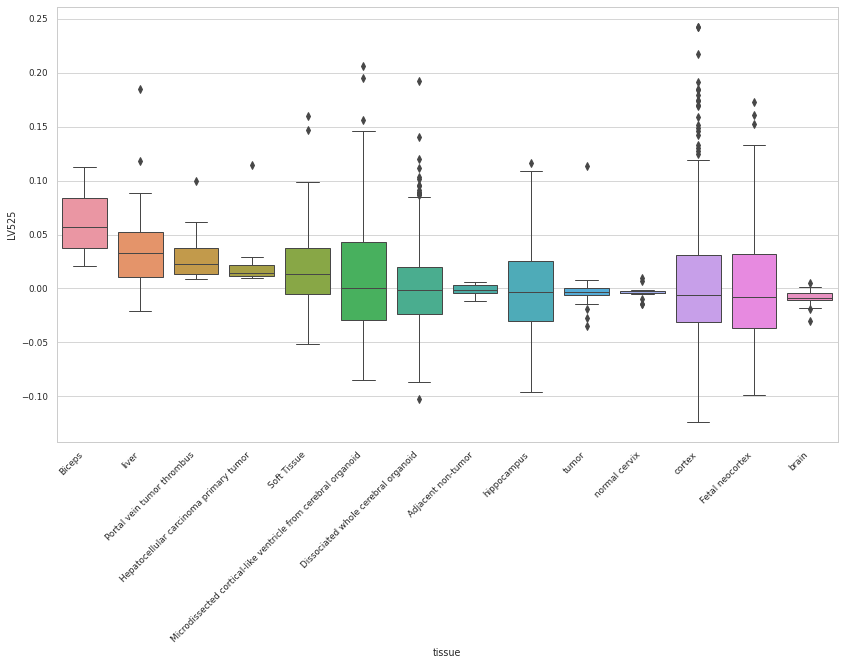

array(['SRP019936'], dtype=object)

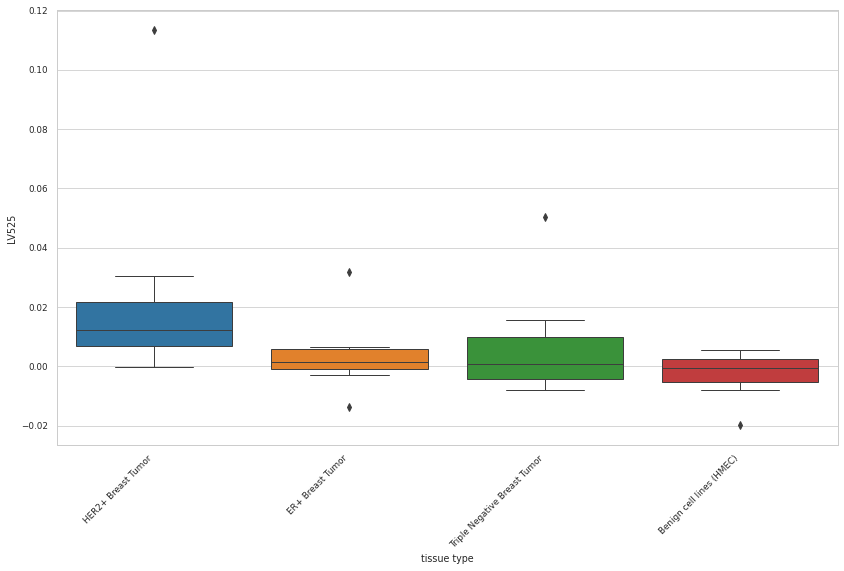

,pathway,LV index,AUC,p-value,FDR


SRP012461, SRP055569, SRP057196, SRP023111, SRP066834, SRP058773, SRP002184, SRP042161, SRP009266, SRP015976, SRP033135, SRP007947, SRP064464, SRP063840, SRP003901, SRP055153, SRP060416, SRP050499, SRP057205, SRP009247, SRP024268, SRP044956, SRP014542, SRP059379, SRP059035, SRP013239, SRP010350, SRP015853, SRP017411, SRP015449, SRP009862, SRP018256, SRP055810, SRP011546, SRP027383, SRP006575, SRP014620, SRP003227, SRP041130, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (37 != 39)
  warnings.warn(


''

1747_4-Hair_colour_natural_before_greying_Dark_brown                                                                  5.287852
20003_1140856342-Treatmentmedication_code_syndol_tablet                                                               4.545089
1747_1-Hair_colour_natural_before_greying_Blonde                                                                      4.106150
E4_DM2NOCOMP-Type_2_diabetes_without_complications                                                                    3.904342
1747_3-Hair_colour_natural_before_greying_Light_brown                                                                 3.867496
22617_2321-Job_SOC_coding_Scientific_researchers                                                                      3.670564
22601_23213026-Job_coding_scientific_researcher_scientific_officer_medical_research_associate_experimental_officer    3.515391
22617_3563-Job_SOC_coding_Vocational_and_industrial_trainers_and_instructors                                   

''

,gene_name,LV85,gene_band
0,DIRC2,7.141120,3q21.1
1,HES1,5.842397,3q29
2,MRPL43,5.598330,10q24.31
3,DPM2,5.133045,9q34.11
4,PIGS,4.441948,17q11.2
5,USP7,4.331208,16p13.2
6,SRP72,4.180398,4q12
7,PSMB3,4.101901,17q12
8,TAPBP,3.865533,6p21.32
9,C1GALT1C1,3.606269,NaN


cell type      0.039775
tissue         0.001743
tissue type    0.000595
dtype: float64

array(['SRP012461', 'SRP055569', 'SRP057196', 'SRP002184', 'SRP042161',
       'SRP015976', 'SRP033135', 'SRP007947', 'SRP063840', 'SRP055153',
       'SRP060416', 'SRP059379', 'SRP059035', 'SRP015853', 'SRP017411',
       'SRP011546', 'SRP006575', 'SRP014620', 'SRP003227'], dtype=object)

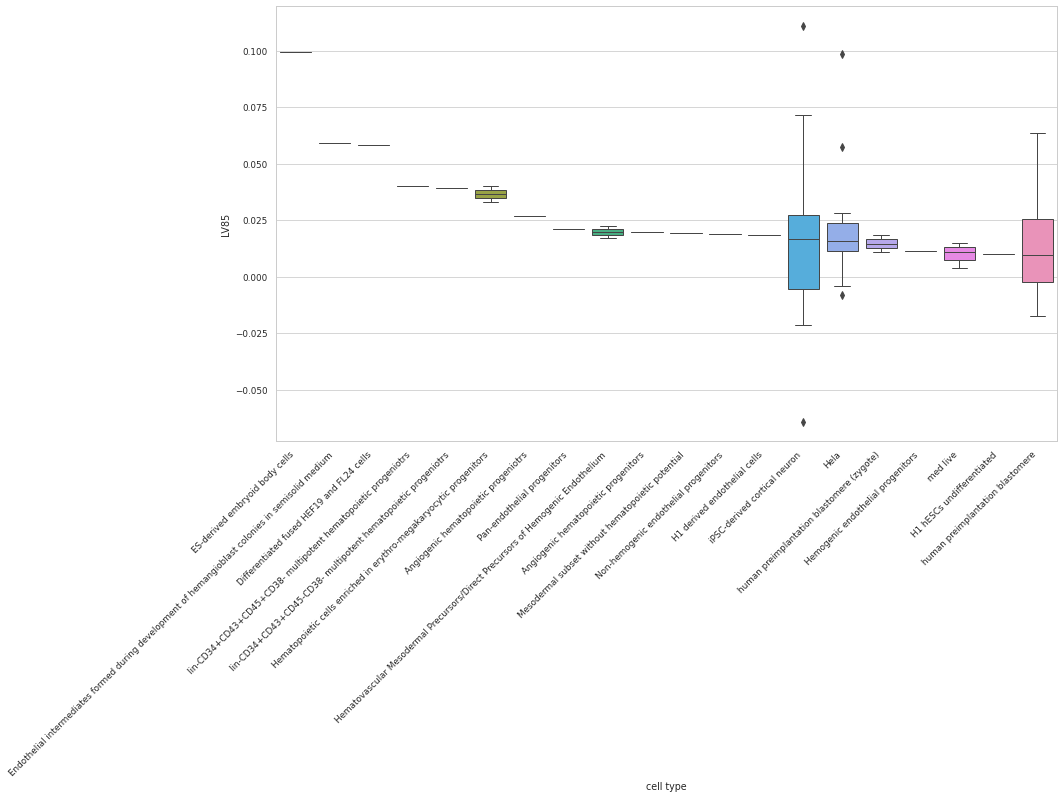

array(['SRP057196', 'SRP066834', 'SRP003901', 'SRP024268', 'SRP044956',
       'SRP011546', 'SRP006575'], dtype=object)

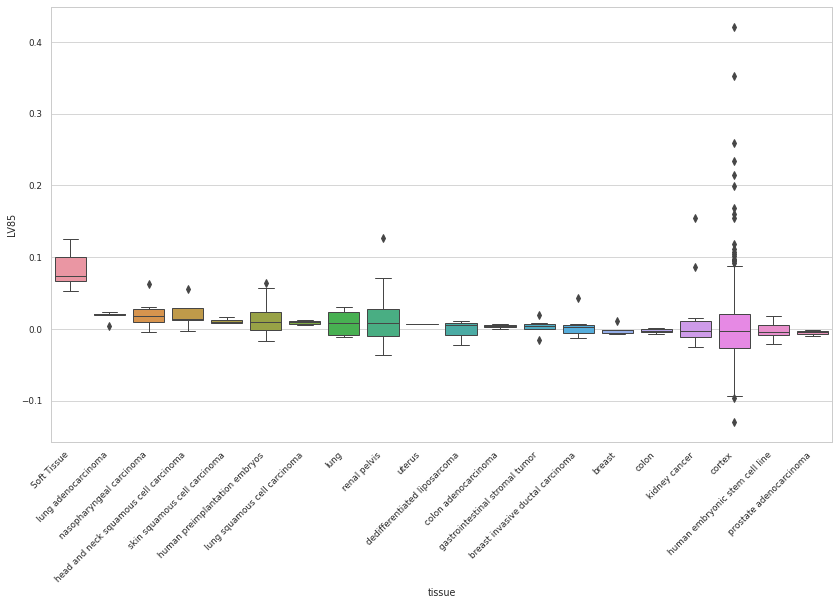

array(['SRP044956'], dtype=object)

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:430: UserWarning: Single value for tissue type: 0.07388564618247687
  warnings.warn(f"Single value for {imp_f}: {cat_order}")


In [28]:
for lv_name in lvs_list:
    display(HTML(f"<h2>{lv_name}</h2>"))

#     lv_name = lv_info["name"]
    lv_obj = lv_exp = LVAnalysis(lv_name, data)

    # show lv prior knowledge match (pathways)
    lv_pathways = multiplier_model_summary[
        multiplier_model_summary["LV index"].isin((lv_name[2:],))
        & (
            (multiplier_model_summary["FDR"] < 0.05)
            | (multiplier_model_summary["AUC"] >= 0.75)
        )
    ]
    display(lv_pathways)

    lv_data = lv_obj.get_experiments_data()

    display("")
    display(lv_obj.lv_traits.head(20))
    display("")
    display(lv_obj.lv_genes.head(10))

    lv_attrs = lv_obj.get_attributes_variation_score()
    _tmp = pd.Series(lv_attrs.index)
    lv_attrs = lv_attrs[
        _tmp.str.match(
            "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
            case=False,
            flags=re.IGNORECASE,
        ).values
    ].sort_values(ascending=False)
    display(lv_attrs)

    for _lva in lv_attrs.index:
        display(HTML(f"<h3>{_lva}</h3>"))
        display(lv_data[_lva].dropna().reset_index()["project"].unique())

        with sns.plotting_context("paper", font_scale=1.0), sns.axes_style("whitegrid"):
            fig, ax = plt.subplots(figsize=(14, 8))
            ax = lv_obj.plot_attribute(_lva, top_x_values=20)
            if ax is None:
                plt.close(fig)
                continue
            display(fig)
            plt.close(fig)